# Detecting spouse mentions in sentences

We will walk through an example text classification task to explore how Snorkel works with user-defined LFs. Run every cell in the notebook (unless otherwise noted) before proceeding to the next one!
## Classification Task
<img src="imgs/sentence.jpg" width="700px;">

We want to classify each __candidate__ or pair of people mentioned in a sentence, as being married at some point or not.

In the above example, our candidate represents the possible relation `(Barack Obama, Michelle Obama)`. As readers, we know this mention is true due to external knowledge and the keyword of `wedding` occuring later in the sentence.
We begin with some basic setup and data downloading.


In [1]:
%matplotlib inline

import os
import pickle
import tensorflow as tf
import numpy as np

if os.path.basename(os.getcwd()) == "snorkel-tutorials":
    os.chdir("spouse")

from utils import load_data

((dev_df, dev_labels), train_df, (test_df, test_labels)) = load_data()

**Input Data:** `dev_df` is a Pandas DataFrame object, where each row represents a particular __candidate__. The DataFrames contain the fields `sentence`, which refers to the sentence the candidate is in, `tokens`, the tokenized form of the sentence, `person1_word_idx` and `person2_word_idx`, which represent `[start, end]` indices in the tokens at which the first and second person's name appear, respectively.

We also have certain **preprocessed fields**, that we discuss a few cells below. We have other tutorials focused on generating such datasets (e.g., from richy-formatted data), but assume we have access to a Pandas DataFrame for the purpose of this specific tutorial!

In [2]:
dev_df.head()

,person1_word_idx,person2_word_idx,sentence,tokens,person1_right_tokens,person2_right_tokens,between_tokens
0,"(1, 1)","(22, 24)","The Richards are half-sisters to Kathy Hilton,...","[The, Richards, are, half, -, sisters, to, Kat...","[are, half, -, sisters]","[., ]","[are, half, -, sisters, to, Kathy, Hilton, ,, ..."
1,"(1, 1)","(7, 8)","The Richards are half-sisters to Kathy Hilton,...","[The, Richards, are, half, -, sisters, to, Kat...","[are, half, -, sisters]","[,, the, mother, of]","[are, half, -, sisters, to]"
2,"(7, 8)","(22, 24)","The Richards are half-sisters to Kathy Hilton,...","[The, Richards, are, half, -, sisters, to, Kat...","[,, the, mother, of]","[., ]","[,, the, mother, of, socialite, Paris, Hilton,..."
3,"(6, 6)","(20, 21)","Prior to both his guests, Colbert's monologue ...","[Prior, to, both, his, guests, ,, Colbert, s, ...","[s, monologue, -, parts]","[and, his, oft, -]","[s, monologue, -, parts, of, which, he, did, s..."
4,"(2, 2)","(4, 5)",People reported Williams and Ven Veen tied the...,"[People, reported, Williams, and, Ven, Veen, t...","[and, Ven, Veen, tied]","[tied, the, knot, Saturday]",[and]


You'll interact with these candidates while writing labeling functions in Snorkel. We look at a candidate in the development set:

In [3]:
from preprocessors import get_person_text

candidate = dev_df.loc[2]
person_names = get_person_text(candidate).person_names

print("Sentence: ", candidate["sentence"])
print("Person 1: ", person_names[0])
print("Person 2: ", person_names[1])

Sentence:  The Richards are half-sisters to Kathy Hilton, the mother of socialite Paris Hilton and spouse of luxury hotel magnate Richard Howard Hilton.   
Person 1:  Kathy Hilton
Person 2:  Richard Howard Hilton


# Part 2: Writing  Labeling Functions

In Snorkel, our primary interface through which we provide training signal to the end extraction model we are training is by writing **labeling functions (LFs)** (as opposed to hand-labeling massive training sets).  We'll go through some examples for our spouse classification task below.

A labeling function is a Python function that accepts a candidate, or a row of the DataFrame, as the input argument and outputs a label for the candidate. For ease of exposition in this notebook, we return `1` if it says the pair of persons in the candidate were married at some point,  `-1` if the pair of persons in the candidate were never married, and `0` if it doesn't know how to vote and abstains. In practice, many labeling functions are often unipolar: it labels only `1`s and `0`s, or it labels only `-1`s and `0`s.

(Note we will change our mapping to use `2` to represent the absence of a relationship to match the multiclass convention when feeding it to the LabelModel later.)
Recall that our goal is to ultimately train a high-performance classification model that predicts which of our candidates are true spouse relations. It turns out that we can do this by writing potentially low-quality labeling functions!

#  I. Background

## Preprocessing the Database

In a real application, there is a lot of data preparation, parsing, and database loading that needs to be completed before we dive into writing labeling functions. Here we've pre-generated candidates in a pandas DataFrame object per split (train,dev,test).

###  Using a _Development Set_ of Human-labeled Data

In our setting, we will use the phrase _development set_ to refer to a set of examples (here, a subset of our training set) which we label by hand and use to help us develop and refine labeling functions.  Unlike the _test set_, which we do not look at and use for final evaluation, we can inspect the development set while writing labeling functions. This is a list of `{-1,1}` labels.

### Labeling Function Helpers

When writing labeling functions, there are several operators you will use over and over again. In the case of text relation extraction as with this task, common operators include fetching text between mentions of the two people in a candidate, examing word windows around person mentions, etc. Note that other domains and tasks, the required preprocessors will be different.

We provide several helper functions in `preprocessors`:  these are Python helper functions that you can apply to candidates in the DataFrame to return objects that are helpful during LF development. You can (and should!) write your own helper functions to help write LFs.

We provide an example of a preprocessor definition here:

In [4]:
from snorkel.labeling.preprocess import preprocessor


@preprocessor
def get_text_between(cand):
    """
    Returns the text between the two person mentions in the sentence for a candidate
    """
    start = cand.person1_word_idx[1] + 1
    end = cand.person2_word_idx[0]
    cand.text_between = " ".join(cand.tokens[start:end])
    return cand

## Candidate PreProcessors

We provide a set of helper functions for this task in `preprocessors.py` that take as input a candidate, or row of a DataFrame in our case. For the purpose of the tutorial, we have two of these fields preprocessed in the data, which can be used when creating labeling functions.

`get_person_text(cand)`

`get_person_lastnames(cand)`

`get_between_tokens(cand)`

`get_left_tokens(cand)`

`get_right_tokens(cand)`

II. Labeling Functions

# A. Pattern Matching Labeling Functions

One powerful form of labeling function design is defining sets of keywords or regular expressions that, as a human labeler, you know are correlated with the true label. For example, we could define a dictionary of terms that occur between person names in a candidate. One simple dictionary of terms indicating a true relation could be, which we could use in a labeling function like shown below:

    spouses = {'spouse', 'wife', 'husband', 'ex-wife', 'ex-husband'}


    @labeling_function(resources=dict(spouses=spouses), preprocessors=[get_left_tokens])
    def lf_husband_wife_left_window(x, spouses):
        if len(set(spouses).intersection(set(x.person1_left_tokens))) > 0:
            return POSITIVE
        elif len(set(spouses).intersection(set(x.person2_left_tokens))) > 0:
            return POSITIVE
        else:
            return ABSTAIN

**Note that:**
1. To access the text between the person mentions, we can use the **`get_left_tokens` preprocessor!**
2. We use **resources like the spouses dictionary** to encode themes/categories of relationships!

There are a few advantages of having preprocessors and labeling functions in this form:

**Data Agnostic:**  Operate over multiple data types without rewriting

**Incremental Processing:** Can create preprocessors as needed while writing LFs!

**Future Use:** Can store them for later for different tasks since they are reproducible and modular

**Optimizations:** Allows caching behind-the-scenes

In [5]:
from snorkel.labeling.apply import PandasLFApplier
from snorkel.labeling.lf import labeling_function

from preprocessors import get_left_tokens, get_person_last_names

POSITIVE = 1
NEGATIVE = 0
ABSTAIN = -1

In [6]:
# Check for the `spouse` words appearing between the person mentions
spouses = {"spouse", "wife", "husband", "ex-wife", "ex-husband"}


@labeling_function(resources=dict(spouses=spouses))
def lf_husband_wife(x, spouses):
    return POSITIVE if len(spouses.intersection(set(x.between_tokens))) > 0 else ABSTAIN

In [7]:
# Check for the `spouse` words appearing to the left of the person mentions
@labeling_function(resources=dict(spouses=spouses), preprocessors=[get_left_tokens])
def lf_husband_wife_left_window(x, spouses):
    if len(set(spouses).intersection(set(x.person1_left_tokens))) > 0:
        return POSITIVE
    elif len(set(spouses).intersection(set(x.person2_left_tokens))) > 0:
        return POSITIVE
    else:
        return ABSTAIN

In [8]:
# Check for the person mentions having the same last name
@labeling_function(preprocessors=[get_person_last_names])
def lf_same_last_name(x):
    p1_ln, p2_ln = x.person_lastnames

    if p1_ln and p2_ln and p1_ln == p2_ln:
        return POSITIVE
    return ABSTAIN

In [9]:
# Check for the word `married` between person mentions
@labeling_function()
def lf_married(x):
    return POSITIVE if "married" in x.between_tokens else ABSTAIN

In [10]:
# Check for words that refer to `family` relationships between and to the left of the person mentions
family = [
    "father",
    "mother",
    "sister",
    "brother",
    "son",
    "daughter",
    "grandfather",
    "grandmother",
    "uncle",
    "aunt",
    "cousin",
]
family = set(family + [f + "-in-law" for f in family])


@labeling_function(resources=dict(family=family))
def lf_familial_relationship(x, family):
    return NEGATIVE if len(family.intersection(set(x.between_tokens))) > 0 else ABSTAIN


@labeling_function(resources=dict(family=family), preprocessors=[get_left_tokens])
def lf_family_left_window(x, family):
    if len(set(family).intersection(set(x.person1_left_tokens))) > 0:
        return NEGATIVE
    elif len(set(family).intersection(set(x.person2_left_tokens))) > 0:
        return NEGATIVE
    else:
        return ABSTAIN

In [11]:
# Check for `other` relationship words between person mentions
other = {"boyfriend", "girlfriend", "boss", "employee", "secretary", "co-worker"}


@labeling_function(resources=dict(other=other))
def lf_other_relationship(x, other):
    return NEGATIVE if len(other.intersection(set(x.between_tokens))) > 0 else ABSTAIN

#### Apply Labeling Functions to the Data
We create a list of labeling functions and apply them to the data

In [12]:
lfs = [
    lf_husband_wife,
    lf_husband_wife_left_window,
    lf_same_last_name,
    lf_married,
    lf_familial_relationship,
    lf_family_left_window,
    lf_other_relationship,
]
applier = PandasLFApplier(lfs)
L = applier.apply(dev_df)

  0%|          | 0/2811 [00:00<?, ?it/s]

  2%|▏         | 64/2811 [00:00<00:04, 638.71it/s]

  5%|▍         | 129/2811 [00:00<00:04, 641.12it/s]

  7%|▋         | 193/2811 [00:00<00:04, 639.19it/s]

  9%|▉         | 257/2811 [00:00<00:04, 637.56it/s]

 11%|█▏        | 322/2811 [00:00<00:03, 640.50it/s]

 14%|█▎        | 385/2811 [00:00<00:03, 635.62it/s]

 16%|█▌        | 449/2811 [00:00<00:03, 636.62it/s]

 18%|█▊        | 514/2811 [00:00<00:03, 639.23it/s]

 21%|██        | 578/2811 [00:00<00:03, 639.37it/s]

 23%|██▎       | 644/2811 [00:01<00:03, 643.46it/s]

 25%|██▌       | 708/2811 [00:01<00:03, 642.18it/s]

 27%|██▋       | 773/2811 [00:01<00:03, 644.06it/s]

 30%|██▉       | 838/2811 [00:01<00:03, 643.22it/s]

 32%|███▏      | 903/2811 [00:01<00:02, 642.96it/s]

 34%|███▍      | 968/2811 [00:01<00:02, 644.94it/s]

 37%|███▋      | 1033/2811 [00:01<00:02, 640.96it/s]

 39%|███▉      | 1097/2811 [00:01<00:02, 640.21it/s]

 41%|████▏     | 1162/2811 [00:01<00:02, 642.57it/s]

 44%|████▎     | 1227/2811 [00:01<00:02, 643.19it/s]

 46%|████▌     | 1292/2811 [00:02<00:02, 643.39it/s]

 48%|████▊     | 1358/2811 [00:02<00:02, 646.47it/s]

 51%|█████     | 1423/2811 [00:02<00:02, 645.90it/s]

 53%|█████▎    | 1488/2811 [00:02<00:02, 645.77it/s]

 55%|█████▌    | 1553/2811 [00:02<00:01, 646.14it/s]

 58%|█████▊    | 1618/2811 [00:02<00:01, 643.77it/s]

 60%|█████▉    | 1683/2811 [00:02<00:01, 644.58it/s]

 62%|██████▏   | 1748/2811 [00:02<00:01, 644.93it/s]

 64%|██████▍   | 1813/2811 [00:02<00:01, 643.15it/s]

 67%|██████▋   | 1879/2811 [00:02<00:01, 645.76it/s]

 69%|██████▉   | 1945/2811 [00:03<00:01, 647.29it/s]

 72%|███████▏  | 2010/2811 [00:03<00:01, 644.94it/s]

 74%|███████▍  | 2075/2811 [00:03<00:01, 641.25it/s]

 76%|███████▌  | 2140/2811 [00:03<00:01, 642.74it/s]

 78%|███████▊  | 2205/2811 [00:03<00:00, 643.47it/s]

 81%|████████  | 2270/2811 [00:03<00:00, 644.89it/s]

 83%|████████▎ | 2335/2811 [00:03<00:00, 643.84it/s]

 85%|████████▌ | 2400/2811 [00:03<00:00, 645.42it/s]

 88%|████████▊ | 2465/2811 [00:03<00:00, 645.64it/s]

 90%|█████████ | 2530/2811 [00:03<00:00, 644.19it/s]

 92%|█████████▏| 2595/2811 [00:04<00:00, 639.72it/s]

 95%|█████████▍| 2660/2811 [00:04<00:00, 642.71it/s]

 97%|█████████▋| 2725/2811 [00:04<00:00, 644.15it/s]

 99%|█████████▉| 2790/2811 [00:04<00:00, 645.40it/s]

100%|██████████| 2811/2811 [00:04<00:00, 642.82it/s]

### Labeling Function Metrics

We can use the lf_summary function to measure various coverage related metrics for LFs. If we have gold labeled data, we can also evaluate accuracy.

#### Polarity
The set of label values the LF can output when it doesn't abstain. It is common for each LF to have a single polarity.

#### Coverage
The fraction of candidates that is labeled by our LF.

#### Overlaps
The fraction of examples labeled by the LF that is also labeled by another LF.

#### Conflicts
The fraction of examples labeled by the LF that is given a different (non-abstain) label by another LF.

#### Correct
The number of correctly labeled examples on the gold labeled data.

#### Incorrect
The number of incorrectly labeled examples on the gold labeled data.

#### Empirical Accuracy
The fraction of correctly labeled examples on the gold data.

In [13]:
from snorkel.labeling.analysis import LFAnalysis

lf_names = [lf.name for lf in lfs]
LFAnalysis(L).lf_summary(dev_labels, lf_names=lf_names)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
lf_husband_wife,0,[1],0.089648,0.036642,0.017432,93,159,0.369048
lf_husband_wife_left_window,1,[1],0.025258,0.021345,0.003557,30,41,0.422535
lf_same_last_name,2,[1],0.040555,0.016009,0.008538,19,95,0.166667
lf_married,3,[1],0.019210,0.006403,0.002490,22,32,0.407407
lf_familial_relationship,4,[0],0.115617,0.051583,0.025969,310,15,0.953846
lf_family_left_window,5,[0],0.041266,0.033440,0.007826,114,2,0.982759
lf_other_relationship,6,[0],0.013874,0.002846,0.002846,33,6,0.846154


## B. Distant Supervision Labeling Functions

In addition to using factories that encode pattern matching heuristics, we can also write labeling functions that _distantly supervise_ examples. Here, we'll load in a list of known spouse pairs and check to see if the pair of persons in a candidate matches one of these.

**DBpedia**
http://wiki.dbpedia.org/
Our database of known spouses comes from DBpedia, which is a community-driven resource similar to Wikipedia but for curating structured data. We'll use a preprocessed snapshot as our knowledge base for all labeling function development.

We can look at some of the example entries from DBPedia and use them in a simple distant supervision labeling function.

Make sure `dbpedia.pkl` is in the `spouse/data` directory.

In [14]:
with open("data/dbpedia.pkl", "rb") as f:
    known_spouses = pickle.load(f)

list(known_spouses)[0:5]

[('Charles Erskine Scott Wood', 'Sara Bard Field'),
 ('Blanche of Artois', 'Henry I of Navarre'),
 ('Judi Chamberlin', 'Ted Chabasinski'),
 ('Jaclyn Smith', 'Roger Davis'),
 ('Ludowika Margaretha of Zweibrücken-Bitsch',
  'Philip V of Hanau-Lichtenberg')]

In [15]:
@labeling_function(
    resources=dict(known_spouses=known_spouses), preprocessors=[get_person_text]
)
def lf_distant_supervision(x, known_spouses):
    p1, p2 = x.person_names
    if (p1, p2) in known_spouses or (p2, p1) in known_spouses:
        return POSITIVE
    else:
        return ABSTAIN

In [16]:
# Helper function to get last name for dbpedia entries.
def last_name(s):
    name_parts = s.split(" ")
    return name_parts[-1] if len(name_parts) > 1 else None


# Last name pairs for known spouses
last_names = set(
    [
        (last_name(x), last_name(y))
        for x, y in known_spouses
        if last_name(x) and last_name(y)
    ]
)


@labeling_function(
    resources=dict(last_names=last_names), preprocessors=[get_person_last_names]
)
def lf_distant_supervision_last_names(x, last_names):
    p1_ln, p2_ln = x.person_lastnames

    return (
        POSITIVE
        if (p1_ln != p2_ln)
        and ((p1_ln, p2_ln) in last_names or (p2_ln, p1_ln) in last_names)
        else ABSTAIN
    )

Every time you write a new labeling function, add it to appliers and make sure to include it in the new L matrix!

In [17]:
lfs = [
    lf_husband_wife,
    lf_husband_wife_left_window,
    lf_same_last_name,
    lf_married,
    lf_familial_relationship,
    lf_family_left_window,
    lf_other_relationship,
    lf_distant_supervision,
    lf_distant_supervision_last_names,
]
applier = PandasLFApplier(lfs)

In [18]:
dev_L = applier.apply(dev_df)

train_L = applier.apply(train_df)

  0%|          | 0/2811 [00:00<?, ?it/s]

  1%|▏         | 38/2811 [00:00<00:07, 379.11it/s]

  3%|▎         | 76/2811 [00:00<00:07, 377.68it/s]

  4%|▍         | 115/2811 [00:00<00:07, 378.89it/s]

  5%|▌         | 153/2811 [00:00<00:07, 378.25it/s]

  7%|▋         | 191/2811 [00:00<00:06, 376.70it/s]

  8%|▊         | 228/2811 [00:00<00:06, 374.29it/s]

  9%|▉         | 266/2811 [00:00<00:06, 375.40it/s]

 11%|█         | 304/2811 [00:00<00:06, 375.88it/s]

 12%|█▏        | 341/2811 [00:00<00:06, 372.15it/s]

 13%|█▎        | 379/2811 [00:01<00:06, 372.09it/s]

 15%|█▍        | 416/2811 [00:01<00:06, 370.90it/s]

 16%|█▌        | 455/2811 [00:01<00:06, 373.87it/s]

 18%|█▊        | 493/2811 [00:01<00:06, 375.60it/s]

 19%|█▉        | 531/2811 [00:01<00:06, 376.69it/s]

 20%|██        | 569/2811 [00:01<00:05, 376.76it/s]

 22%|██▏       | 608/2811 [00:01<00:05, 378.62it/s]

 23%|██▎       | 647/2811 [00:01<00:05, 380.51it/s]

 24%|██▍       | 685/2811 [00:01<00:05, 379.10it/s]

 26%|██▌       | 724/2811 [00:01<00:05, 380.14it/s]

 27%|██▋       | 763/2811 [00:02<00:05, 381.08it/s]

 29%|██▊       | 802/2811 [00:02<00:05, 380.52it/s]

 30%|██▉       | 841/2811 [00:02<00:05, 380.76it/s]

 31%|███▏      | 880/2811 [00:02<00:05, 379.82it/s]

 33%|███▎      | 919/2811 [00:02<00:04, 380.44it/s]

 34%|███▍      | 958/2811 [00:02<00:04, 381.30it/s]

 35%|███▌      | 997/2811 [00:02<00:04, 380.01it/s]

 37%|███▋      | 1035/2811 [00:02<00:04, 377.84it/s]

 38%|███▊      | 1073/2811 [00:02<00:04, 377.43it/s]

 40%|███▉      | 1111/2811 [00:02<00:04, 377.70it/s]

 41%|████      | 1149/2811 [00:03<00:04, 378.29it/s]

 42%|████▏     | 1188/2811 [00:03<00:04, 379.50it/s]

 44%|████▎     | 1226/2811 [00:03<00:04, 378.86it/s]

 45%|████▍     | 1264/2811 [00:03<00:04, 379.13it/s]

 46%|████▋     | 1303/2811 [00:03<00:03, 379.61it/s]

 48%|████▊     | 1342/2811 [00:03<00:03, 381.08it/s]

 49%|████▉     | 1381/2811 [00:03<00:03, 382.83it/s]

 51%|█████     | 1420/2811 [00:03<00:03, 382.66it/s]

 52%|█████▏    | 1459/2811 [00:03<00:03, 383.68it/s]

 53%|█████▎    | 1498/2811 [00:03<00:03, 382.51it/s]

 55%|█████▍    | 1537/2811 [00:04<00:03, 382.43it/s]

 56%|█████▌    | 1576/2811 [00:04<00:03, 382.59it/s]

 57%|█████▋    | 1615/2811 [00:04<00:03, 381.02it/s]

 59%|█████▉    | 1654/2811 [00:04<00:03, 381.83it/s]

 60%|██████    | 1693/2811 [00:04<00:02, 381.60it/s]

 62%|██████▏   | 1732/2811 [00:04<00:02, 380.80it/s]

 63%|██████▎   | 1771/2811 [00:04<00:02, 381.24it/s]

 64%|██████▍   | 1810/2811 [00:04<00:02, 378.63it/s]

 66%|██████▌   | 1849/2811 [00:04<00:02, 379.41it/s]

 67%|██████▋   | 1888/2811 [00:04<00:02, 380.44it/s]

 69%|██████▊   | 1927/2811 [00:05<00:02, 381.98it/s]

 70%|██████▉   | 1966/2811 [00:05<00:02, 383.02it/s]

 71%|███████▏  | 2005/2811 [00:05<00:02, 380.46it/s]

 73%|███████▎  | 2044/2811 [00:05<00:02, 376.51it/s]

 74%|███████▍  | 2082/2811 [00:05<00:01, 376.50it/s]

 75%|███████▌  | 2120/2811 [00:05<00:01, 377.17it/s]

 77%|███████▋  | 2159/2811 [00:05<00:01, 378.46it/s]

 78%|███████▊  | 2198/2811 [00:05<00:01, 379.05it/s]

 80%|███████▉  | 2237/2811 [00:05<00:01, 379.98it/s]

 81%|████████  | 2276/2811 [00:06<00:01, 379.88it/s]

 82%|████████▏ | 2314/2811 [00:06<00:01, 379.82it/s]

 84%|████████▎ | 2353/2811 [00:06<00:01, 379.98it/s]

 85%|████████▌ | 2391/2811 [00:06<00:01, 379.20it/s]

 86%|████████▋ | 2429/2811 [00:06<00:01, 378.67it/s]

 88%|████████▊ | 2468/2811 [00:06<00:00, 379.34it/s]

 89%|████████▉ | 2507/2811 [00:06<00:00, 380.32it/s]

 91%|█████████ | 2546/2811 [00:06<00:00, 381.82it/s]

 92%|█████████▏| 2585/2811 [00:06<00:00, 381.66it/s]

 93%|█████████▎| 2624/2811 [00:06<00:00, 382.68it/s]

 95%|█████████▍| 2663/2811 [00:07<00:00, 382.69it/s]

 96%|█████████▌| 2702/2811 [00:07<00:00, 382.85it/s]

 98%|█████████▊| 2741/2811 [00:07<00:00, 381.40it/s]

 99%|█████████▉| 2780/2811 [00:07<00:00, 382.35it/s]

100%|██████████| 2811/2811 [00:07<00:00, 379.33it/s]


  0%|          | 0/22254 [00:00<?, ?it/s]

  0%|          | 36/22254 [00:00<01:02, 355.25it/s]

  0%|          | 74/22254 [00:00<01:01, 361.01it/s]

  1%|          | 112/22254 [00:00<01:00, 365.42it/s]

  1%|          | 150/22254 [00:00<01:00, 367.55it/s]

  1%|          | 188/22254 [00:00<00:59, 370.49it/s]

  1%|          | 227/22254 [00:00<00:58, 373.82it/s]

  1%|          | 266/22254 [00:00<00:58, 375.92it/s]

  1%|▏         | 304/22254 [00:00<00:58, 377.02it/s]

  2%|▏         | 342/22254 [00:00<00:58, 377.27it/s]

  2%|▏         | 380/22254 [00:01<00:58, 375.97it/s]

  2%|▏         | 418/22254 [00:01<00:58, 375.99it/s]

  2%|▏         | 456/22254 [00:01<00:57, 377.14it/s]

  2%|▏         | 495/22254 [00:01<00:57, 378.31it/s]

  2%|▏         | 533/22254 [00:01<00:58, 373.50it/s]

  3%|▎         | 571/22254 [00:01<00:58, 371.68it/s]

  3%|▎         | 609/22254 [00:01<00:57, 373.98it/s]

  3%|▎         | 647/22254 [00:01<00:57, 373.92it/s]

  3%|▎         | 685/22254 [00:01<00:57, 373.56it/s]

  3%|▎         | 724/22254 [00:01<00:57, 376.54it/s]

  3%|▎         | 763/22254 [00:02<00:56, 377.60it/s]

  4%|▎         | 801/22254 [00:02<00:56, 377.83it/s]

  4%|▍         | 840/22254 [00:02<00:56, 378.52it/s]

  4%|▍         | 878/22254 [00:02<00:56, 377.90it/s]

  4%|▍         | 917/22254 [00:02<00:56, 378.67it/s]

  4%|▍         | 956/22254 [00:02<00:56, 379.46it/s]

  4%|▍         | 994/22254 [00:02<00:56, 379.40it/s]

  5%|▍         | 1032/22254 [00:02<00:56, 378.25it/s]

  5%|▍         | 1070/22254 [00:02<00:56, 377.79it/s]

  5%|▍         | 1108/22254 [00:02<00:56, 377.09it/s]

  5%|▌         | 1147/22254 [00:03<00:55, 378.38it/s]

  5%|▌         | 1186/22254 [00:03<00:55, 379.11it/s]

  6%|▌         | 1224/22254 [00:03<00:55, 378.56it/s]

  6%|▌         | 1263/22254 [00:03<00:55, 380.21it/s]

  6%|▌         | 1302/22254 [00:03<00:54, 381.58it/s]

  6%|▌         | 1341/22254 [00:03<00:54, 381.07it/s]

  6%|▌         | 1380/22254 [00:03<00:54, 380.84it/s]

  6%|▋         | 1419/22254 [00:03<00:55, 374.73it/s]

  7%|▋         | 1457/22254 [00:03<00:55, 375.35it/s]

  7%|▋         | 1495/22254 [00:03<00:55, 376.09it/s]

  7%|▋         | 1534/22254 [00:04<00:54, 377.33it/s]

  7%|▋         | 1572/22254 [00:04<00:54, 377.12it/s]

  7%|▋         | 1610/22254 [00:04<00:54, 376.77it/s]

  7%|▋         | 1648/22254 [00:04<00:54, 376.94it/s]

  8%|▊         | 1686/22254 [00:04<00:54, 376.56it/s]

  8%|▊         | 1724/22254 [00:04<00:54, 376.34it/s]

  8%|▊         | 1762/22254 [00:04<00:54, 376.29it/s]

  8%|▊         | 1801/22254 [00:04<00:54, 377.50it/s]

  8%|▊         | 1840/22254 [00:04<00:53, 378.96it/s]

  8%|▊         | 1879/22254 [00:04<00:53, 380.13it/s]

  9%|▊         | 1918/22254 [00:05<00:54, 370.17it/s]

  9%|▉         | 1956/22254 [00:05<00:54, 372.67it/s]

  9%|▉         | 1994/22254 [00:05<00:54, 373.90it/s]

  9%|▉         | 2032/22254 [00:05<00:53, 375.49it/s]

  9%|▉         | 2070/22254 [00:05<00:53, 375.94it/s]

  9%|▉         | 2108/22254 [00:05<00:53, 375.60it/s]

 10%|▉         | 2146/22254 [00:05<00:53, 375.35it/s]

 10%|▉         | 2184/22254 [00:05<00:53, 375.98it/s]

 10%|▉         | 2222/22254 [00:05<00:53, 375.36it/s]

 10%|█         | 2261/22254 [00:06<00:53, 377.19it/s]

 10%|█         | 2300/22254 [00:06<00:52, 378.50it/s]

 11%|█         | 2338/22254 [00:06<00:52, 376.89it/s]

 11%|█         | 2376/22254 [00:06<00:52, 377.34it/s]

 11%|█         | 2414/22254 [00:06<00:52, 374.86it/s]

 11%|█         | 2452/22254 [00:06<00:52, 375.48it/s]

 11%|█         | 2490/22254 [00:06<00:52, 376.56it/s]

 11%|█▏        | 2528/22254 [00:06<00:52, 375.95it/s]

 12%|█▏        | 2566/22254 [00:06<00:52, 376.00it/s]

 12%|█▏        | 2604/22254 [00:06<00:52, 376.75it/s]

 12%|█▏        | 2642/22254 [00:07<00:52, 373.23it/s]

 12%|█▏        | 2680/22254 [00:07<00:52, 372.21it/s]

 12%|█▏        | 2719/22254 [00:07<00:52, 374.67it/s]

 12%|█▏        | 2757/22254 [00:07<00:52, 374.27it/s]

 13%|█▎        | 2795/22254 [00:07<00:52, 373.19it/s]

 13%|█▎        | 2833/22254 [00:07<00:52, 372.44it/s]

 13%|█▎        | 2872/22254 [00:07<00:51, 374.67it/s]

 13%|█▎        | 2910/22254 [00:07<00:51, 375.70it/s]

 13%|█▎        | 2948/22254 [00:07<00:51, 376.87it/s]

 13%|█▎        | 2986/22254 [00:07<00:51, 377.02it/s]

 14%|█▎        | 3024/22254 [00:08<00:50, 377.51it/s]

 14%|█▍        | 3062/22254 [00:08<00:50, 376.97it/s]

 14%|█▍        | 3100/22254 [00:08<00:50, 377.64it/s]

 14%|█▍        | 3138/22254 [00:08<00:50, 377.19it/s]

 14%|█▍        | 3176/22254 [00:08<00:50, 376.25it/s]

 14%|█▍        | 3214/22254 [00:08<00:50, 376.57it/s]

 15%|█▍        | 3252/22254 [00:08<00:50, 376.97it/s]

 15%|█▍        | 3291/22254 [00:08<00:50, 377.91it/s]

 15%|█▍        | 3329/22254 [00:08<00:50, 377.66it/s]

 15%|█▌        | 3367/22254 [00:08<00:50, 376.96it/s]

 15%|█▌        | 3405/22254 [00:09<00:49, 377.39it/s]

 15%|█▌        | 3443/22254 [00:09<00:49, 376.85it/s]

 16%|█▌        | 3481/22254 [00:09<00:50, 374.30it/s]

 16%|█▌        | 3519/22254 [00:09<00:49, 375.33it/s]

 16%|█▌        | 3557/22254 [00:09<00:50, 373.25it/s]

 16%|█▌        | 3595/22254 [00:09<00:49, 374.77it/s]

 16%|█▋        | 3633/22254 [00:09<00:49, 375.22it/s]

 16%|█▋        | 3671/22254 [00:09<00:49, 376.13it/s]

 17%|█▋        | 3709/22254 [00:09<00:49, 376.24it/s]

 17%|█▋        | 3747/22254 [00:09<00:49, 375.31it/s]

 17%|█▋        | 3785/22254 [00:10<00:49, 375.53it/s]

 17%|█▋        | 3823/22254 [00:10<00:49, 375.36it/s]

 17%|█▋        | 3861/22254 [00:10<00:48, 376.38it/s]

 18%|█▊        | 3899/22254 [00:10<00:48, 377.23it/s]

 18%|█▊        | 3938/22254 [00:10<00:48, 378.16it/s]

 18%|█▊        | 3976/22254 [00:10<00:48, 377.64it/s]

 18%|█▊        | 4014/22254 [00:10<00:48, 376.54it/s]

 18%|█▊        | 4052/22254 [00:10<00:48, 377.00it/s]

 18%|█▊        | 4091/22254 [00:10<00:48, 378.02it/s]

 19%|█▊        | 4129/22254 [00:10<00:48, 377.43it/s]

 19%|█▊        | 4167/22254 [00:11<00:48, 375.41it/s]

 19%|█▉        | 4205/22254 [00:11<00:48, 374.34it/s]

 19%|█▉        | 4243/22254 [00:11<00:48, 372.46it/s]

 19%|█▉        | 4281/22254 [00:11<00:48, 372.82it/s]

 19%|█▉        | 4319/22254 [00:11<00:47, 373.73it/s]

 20%|█▉        | 4357/22254 [00:11<00:47, 373.53it/s]

 20%|█▉        | 4395/22254 [00:11<00:47, 374.60it/s]

 20%|█▉        | 4433/22254 [00:11<00:47, 373.83it/s]

 20%|██        | 4471/22254 [00:11<00:47, 375.12it/s]

 20%|██        | 4509/22254 [00:11<00:47, 375.12it/s]

 20%|██        | 4548/22254 [00:12<00:47, 376.59it/s]

 21%|██        | 4586/22254 [00:12<00:46, 376.41it/s]

 21%|██        | 4624/22254 [00:12<00:46, 376.81it/s]

 21%|██        | 4662/22254 [00:12<00:46, 376.97it/s]

 21%|██        | 4700/22254 [00:12<00:46, 374.94it/s]

 21%|██▏       | 4738/22254 [00:12<00:47, 371.78it/s]

 21%|██▏       | 4776/22254 [00:12<00:46, 372.87it/s]

 22%|██▏       | 4815/22254 [00:12<00:46, 375.18it/s]

 22%|██▏       | 4853/22254 [00:12<00:46, 375.58it/s]

 22%|██▏       | 4891/22254 [00:13<00:46, 374.27it/s]

 22%|██▏       | 4929/22254 [00:13<00:46, 374.97it/s]

 22%|██▏       | 4967/22254 [00:13<00:45, 376.36it/s]

 22%|██▏       | 5005/22254 [00:13<00:45, 377.31it/s]

 23%|██▎       | 5044/22254 [00:13<00:45, 378.24it/s]

 23%|██▎       | 5082/22254 [00:13<00:45, 375.92it/s]

 23%|██▎       | 5120/22254 [00:13<00:45, 376.67it/s]

 23%|██▎       | 5158/22254 [00:13<00:45, 376.83it/s]

 23%|██▎       | 5196/22254 [00:13<00:45, 375.35it/s]

 24%|██▎       | 5235/22254 [00:13<00:45, 376.82it/s]

 24%|██▎       | 5273/22254 [00:14<00:45, 376.06it/s]

 24%|██▍       | 5311/22254 [00:14<00:44, 376.83it/s]

 24%|██▍       | 5349/22254 [00:14<00:44, 377.71it/s]

 24%|██▍       | 5387/22254 [00:14<00:44, 377.48it/s]

 24%|██▍       | 5425/22254 [00:14<00:44, 376.69it/s]

 25%|██▍       | 5463/22254 [00:14<00:44, 377.11it/s]

 25%|██▍       | 5502/22254 [00:14<00:44, 378.61it/s]

 25%|██▍       | 5541/22254 [00:14<00:44, 379.71it/s]

 25%|██▌       | 5579/22254 [00:14<00:43, 379.35it/s]

 25%|██▌       | 5617/22254 [00:14<00:43, 379.19it/s]

 25%|██▌       | 5655/22254 [00:15<00:43, 378.92it/s]

 26%|██▌       | 5693/22254 [00:15<00:43, 379.04it/s]

 26%|██▌       | 5732/22254 [00:15<00:43, 379.46it/s]

 26%|██▌       | 5770/22254 [00:15<00:43, 379.28it/s]

 26%|██▌       | 5809/22254 [00:15<00:43, 380.31it/s]

 26%|██▋       | 5848/22254 [00:15<00:43, 380.71it/s]

 26%|██▋       | 5887/22254 [00:15<00:42, 380.85it/s]

 27%|██▋       | 5926/22254 [00:15<00:43, 377.94it/s]

 27%|██▋       | 5965/22254 [00:15<00:43, 378.30it/s]

 27%|██▋       | 6003/22254 [00:15<00:43, 377.37it/s]

 27%|██▋       | 6041/22254 [00:16<00:43, 376.89it/s]

 27%|██▋       | 6079/22254 [00:16<00:43, 375.83it/s]

 27%|██▋       | 6117/22254 [00:16<00:43, 374.80it/s]

 28%|██▊       | 6155/22254 [00:16<00:43, 374.27it/s]

 28%|██▊       | 6193/22254 [00:16<00:43, 372.05it/s]

 28%|██▊       | 6231/22254 [00:16<00:43, 370.89it/s]

 28%|██▊       | 6269/22254 [00:16<00:42, 371.75it/s]

 28%|██▊       | 6308/22254 [00:16<00:42, 374.41it/s]

 29%|██▊       | 6346/22254 [00:16<00:42, 375.74it/s]

 29%|██▊       | 6384/22254 [00:16<00:42, 375.81it/s]

 29%|██▉       | 6422/22254 [00:17<00:42, 376.65it/s]

 29%|██▉       | 6460/22254 [00:17<00:41, 377.12it/s]

 29%|██▉       | 6498/22254 [00:17<00:41, 376.26it/s]

 29%|██▉       | 6537/22254 [00:17<00:41, 377.46it/s]

 30%|██▉       | 6575/22254 [00:17<00:41, 373.85it/s]

 30%|██▉       | 6613/22254 [00:17<00:42, 366.61it/s]

 30%|██▉       | 6650/22254 [00:17<00:42, 365.60it/s]

 30%|███       | 6688/22254 [00:17<00:42, 368.97it/s]

 30%|███       | 6726/22254 [00:17<00:41, 371.63it/s]

 30%|███       | 6764/22254 [00:17<00:41, 373.83it/s]

 31%|███       | 6802/22254 [00:18<00:41, 374.41it/s]

 31%|███       | 6840/22254 [00:18<00:41, 374.68it/s]

 31%|███       | 6878/22254 [00:18<00:40, 375.50it/s]

 31%|███       | 6916/22254 [00:18<00:40, 375.24it/s]

 31%|███▏      | 6955/22254 [00:18<00:40, 377.00it/s]

 31%|███▏      | 6993/22254 [00:18<00:41, 370.12it/s]

 32%|███▏      | 7031/22254 [00:18<00:40, 372.91it/s]

 32%|███▏      | 7069/22254 [00:18<00:40, 374.38it/s]

 32%|███▏      | 7107/22254 [00:18<00:40, 375.40it/s]

 32%|███▏      | 7145/22254 [00:19<00:40, 375.14it/s]

 32%|███▏      | 7183/22254 [00:19<00:40, 375.97it/s]

 32%|███▏      | 7221/22254 [00:19<00:39, 376.30it/s]

 33%|███▎      | 7259/22254 [00:19<00:39, 375.89it/s]

 33%|███▎      | 7297/22254 [00:19<00:39, 376.80it/s]

 33%|███▎      | 7335/22254 [00:19<00:39, 376.30it/s]

 33%|███▎      | 7373/22254 [00:19<00:39, 376.41it/s]

 33%|███▎      | 7411/22254 [00:19<00:39, 376.66it/s]

 33%|███▎      | 7449/22254 [00:19<00:39, 375.06it/s]

 34%|███▎      | 7487/22254 [00:19<00:39, 373.70it/s]

 34%|███▍      | 7525/22254 [00:20<00:39, 374.22it/s]

 34%|███▍      | 7563/22254 [00:20<00:39, 374.46it/s]

 34%|███▍      | 7601/22254 [00:20<00:39, 374.87it/s]

 34%|███▍      | 7639/22254 [00:20<00:38, 376.25it/s]

 34%|███▍      | 7677/22254 [00:20<00:38, 375.82it/s]

 35%|███▍      | 7715/22254 [00:20<00:38, 376.74it/s]

 35%|███▍      | 7753/22254 [00:20<00:38, 375.59it/s]

 35%|███▌      | 7791/22254 [00:20<00:38, 376.12it/s]

 35%|███▌      | 7829/22254 [00:20<00:38, 374.48it/s]

 35%|███▌      | 7867/22254 [00:20<00:38, 374.94it/s]

 36%|███▌      | 7905/22254 [00:21<00:38, 375.22it/s]

 36%|███▌      | 7943/22254 [00:21<00:38, 372.76it/s]

 36%|███▌      | 7981/22254 [00:21<00:38, 370.90it/s]

 36%|███▌      | 8019/22254 [00:21<00:38, 370.98it/s]

 36%|███▌      | 8057/22254 [00:21<00:38, 371.43it/s]

 36%|███▋      | 8095/22254 [00:21<00:37, 373.92it/s]

 37%|███▋      | 8133/22254 [00:21<00:37, 374.73it/s]

 37%|███▋      | 8171/22254 [00:21<00:37, 373.45it/s]

 37%|███▋      | 8209/22254 [00:21<00:37, 372.97it/s]

 37%|███▋      | 8247/22254 [00:21<00:37, 374.94it/s]

 37%|███▋      | 8285/22254 [00:22<00:37, 372.86it/s]

 37%|███▋      | 8323/22254 [00:22<00:37, 374.27it/s]

 38%|███▊      | 8361/22254 [00:22<00:37, 373.21it/s]

 38%|███▊      | 8399/22254 [00:22<00:37, 373.70it/s]

 38%|███▊      | 8437/22254 [00:22<00:36, 375.37it/s]

 38%|███▊      | 8475/22254 [00:22<00:36, 376.69it/s]

 38%|███▊      | 8513/22254 [00:22<00:36, 375.47it/s]

 38%|███▊      | 8551/22254 [00:22<00:36, 376.64it/s]

 39%|███▊      | 8589/22254 [00:22<00:36, 377.18it/s]

 39%|███▉      | 8627/22254 [00:22<00:36, 376.59it/s]

 39%|███▉      | 8665/22254 [00:23<00:36, 376.21it/s]

 39%|███▉      | 8703/22254 [00:23<00:36, 374.71it/s]

 39%|███▉      | 8741/22254 [00:23<00:36, 374.36it/s]

 39%|███▉      | 8779/22254 [00:23<00:35, 375.35it/s]

 40%|███▉      | 8818/22254 [00:23<00:35, 377.15it/s]

 40%|███▉      | 8856/22254 [00:23<00:35, 376.04it/s]

 40%|███▉      | 8894/22254 [00:23<00:35, 374.84it/s]

 40%|████      | 8932/22254 [00:23<00:35, 371.10it/s]

 40%|████      | 8970/22254 [00:23<00:35, 371.43it/s]

 40%|████      | 9008/22254 [00:23<00:35, 370.21it/s]

 41%|████      | 9046/22254 [00:24<00:35, 370.96it/s]

 41%|████      | 9085/22254 [00:24<00:35, 373.67it/s]

 41%|████      | 9123/22254 [00:24<00:35, 372.60it/s]

 41%|████      | 9161/22254 [00:24<00:35, 373.94it/s]

 41%|████▏     | 9199/22254 [00:24<00:34, 375.20it/s]

 42%|████▏     | 9237/22254 [00:24<00:34, 371.92it/s]

 42%|████▏     | 9275/22254 [00:24<00:34, 371.50it/s]

 42%|████▏     | 9314/22254 [00:24<00:34, 374.51it/s]

 42%|████▏     | 9353/22254 [00:24<00:34, 376.59it/s]

 42%|████▏     | 9391/22254 [00:24<00:34, 377.35it/s]

 42%|████▏     | 9430/22254 [00:25<00:33, 378.26it/s]

 43%|████▎     | 9468/22254 [00:25<00:33, 377.52it/s]

 43%|████▎     | 9506/22254 [00:25<00:33, 376.93it/s]

 43%|████▎     | 9545/22254 [00:25<00:33, 378.15it/s]

 43%|████▎     | 9583/22254 [00:25<00:33, 377.12it/s]

 43%|████▎     | 9621/22254 [00:25<00:33, 377.78it/s]

 43%|████▎     | 9659/22254 [00:25<00:33, 378.14it/s]

 44%|████▎     | 9697/22254 [00:25<00:33, 378.41it/s]

 44%|████▎     | 9736/22254 [00:25<00:33, 378.82it/s]

 44%|████▍     | 9775/22254 [00:26<00:32, 379.53it/s]

 44%|████▍     | 9813/22254 [00:26<00:32, 378.57it/s]

 44%|████▍     | 9852/22254 [00:26<00:32, 379.09it/s]

 44%|████▍     | 9890/22254 [00:26<00:32, 379.27it/s]

 45%|████▍     | 9929/22254 [00:26<00:32, 380.12it/s]

 45%|████▍     | 9968/22254 [00:26<00:32, 378.91it/s]

 45%|████▍     | 10007/22254 [00:26<00:32, 379.56it/s]

 45%|████▌     | 10045/22254 [00:26<00:32, 379.06it/s]

 45%|████▌     | 10083/22254 [00:26<00:32, 378.13it/s]

 45%|████▌     | 10121/22254 [00:26<00:32, 377.94it/s]

 46%|████▌     | 10159/22254 [00:27<00:31, 378.31it/s]

 46%|████▌     | 10197/22254 [00:27<00:31, 378.70it/s]

 46%|████▌     | 10235/22254 [00:27<00:31, 378.63it/s]

 46%|████▌     | 10273/22254 [00:27<00:31, 378.69it/s]

 46%|████▋     | 10311/22254 [00:27<00:31, 377.76it/s]

 47%|████▋     | 10349/22254 [00:27<00:31, 376.10it/s]

 47%|████▋     | 10387/22254 [00:27<00:31, 375.09it/s]

 47%|████▋     | 10425/22254 [00:27<00:31, 375.28it/s]

 47%|████▋     | 10464/22254 [00:27<00:31, 376.67it/s]

 47%|████▋     | 10502/22254 [00:27<00:31, 377.39it/s]

 47%|████▋     | 10541/22254 [00:28<00:30, 378.58it/s]

 48%|████▊     | 10580/22254 [00:28<00:30, 379.02it/s]

 48%|████▊     | 10618/22254 [00:28<00:30, 376.77it/s]

 48%|████▊     | 10656/22254 [00:28<00:30, 376.13it/s]

 48%|████▊     | 10694/22254 [00:28<00:30, 376.42it/s]

 48%|████▊     | 10732/22254 [00:28<00:30, 375.84it/s]

 48%|████▊     | 10770/22254 [00:28<00:30, 376.77it/s]

 49%|████▊     | 10808/22254 [00:28<00:30, 373.72it/s]

 49%|████▊     | 10847/22254 [00:28<00:30, 376.42it/s]

 49%|████▉     | 10885/22254 [00:28<00:30, 377.24it/s]

 49%|████▉     | 10923/22254 [00:29<00:30, 376.87it/s]

 49%|████▉     | 10961/22254 [00:29<00:29, 376.75it/s]

 49%|████▉     | 10999/22254 [00:29<00:29, 376.41it/s]

 50%|████▉     | 11037/22254 [00:29<00:29, 377.31it/s]

 50%|████▉     | 11076/22254 [00:29<00:29, 378.73it/s]

 50%|████▉     | 11114/22254 [00:29<00:29, 377.41it/s]

 50%|█████     | 11152/22254 [00:29<00:29, 376.26it/s]

 50%|█████     | 11190/22254 [00:29<00:29, 375.90it/s]

 50%|█████     | 11228/22254 [00:29<00:29, 375.44it/s]

 51%|█████     | 11266/22254 [00:29<00:29, 374.80it/s]

 51%|█████     | 11304/22254 [00:30<00:29, 375.22it/s]

 51%|█████     | 11342/22254 [00:30<00:29, 372.85it/s]

 51%|█████     | 11380/22254 [00:30<00:29, 374.79it/s]

 51%|█████▏    | 11418/22254 [00:30<00:29, 372.62it/s]

 51%|█████▏    | 11456/22254 [00:30<00:28, 374.49it/s]

 52%|█████▏    | 11494/22254 [00:30<00:28, 374.25it/s]

 52%|█████▏    | 11532/22254 [00:30<00:28, 373.18it/s]

 52%|█████▏    | 11570/22254 [00:30<00:28, 371.34it/s]

 52%|█████▏    | 11608/22254 [00:30<00:28, 372.73it/s]

 52%|█████▏    | 11646/22254 [00:30<00:28, 372.63it/s]

 53%|█████▎    | 11684/22254 [00:31<00:28, 373.07it/s]

 53%|█████▎    | 11722/22254 [00:31<00:28, 373.46it/s]

 53%|█████▎    | 11760/22254 [00:31<00:28, 374.51it/s]

 53%|█████▎    | 11798/22254 [00:31<00:27, 374.47it/s]

 53%|█████▎    | 11836/22254 [00:31<00:27, 373.52it/s]

 53%|█████▎    | 11874/22254 [00:31<00:27, 374.43it/s]

 54%|█████▎    | 11912/22254 [00:31<00:27, 374.18it/s]

 54%|█████▎    | 11950/22254 [00:31<00:27, 374.75it/s]

 54%|█████▍    | 11988/22254 [00:31<00:27, 375.18it/s]

 54%|█████▍    | 12026/22254 [00:31<00:27, 376.14it/s]

 54%|█████▍    | 12064/22254 [00:32<00:31, 322.49it/s]

 54%|█████▍    | 12098/22254 [00:32<00:33, 301.79it/s]

 55%|█████▍    | 12136/22254 [00:32<00:31, 319.88it/s]

 55%|█████▍    | 12174/22254 [00:32<00:30, 334.03it/s]

 55%|█████▍    | 12212/22254 [00:32<00:29, 344.54it/s]

 55%|█████▌    | 12250/22254 [00:32<00:28, 353.63it/s]

 55%|█████▌    | 12288/22254 [00:32<00:27, 360.11it/s]

 55%|█████▌    | 12326/22254 [00:32<00:27, 365.62it/s]

 56%|█████▌    | 12364/22254 [00:32<00:26, 367.83it/s]

 56%|█████▌    | 12402/22254 [00:33<00:26, 370.76it/s]

 56%|█████▌    | 12441/22254 [00:33<00:26, 373.68it/s]

 56%|█████▌    | 12479/22254 [00:33<00:26, 374.70it/s]

 56%|█████▌    | 12517/22254 [00:33<00:25, 375.77it/s]

 56%|█████▋    | 12555/22254 [00:33<00:25, 376.75it/s]

 57%|█████▋    | 12594/22254 [00:33<00:25, 378.26it/s]

 57%|█████▋    | 12632/22254 [00:33<00:25, 377.35it/s]

 57%|█████▋    | 12671/22254 [00:33<00:25, 378.36it/s]

 57%|█████▋    | 12709/22254 [00:33<00:25, 377.62it/s]

 57%|█████▋    | 12747/22254 [00:34<00:25, 377.35it/s]

 57%|█████▋    | 12785/22254 [00:34<00:25, 376.42it/s]

 58%|█████▊    | 12823/22254 [00:34<00:24, 377.42it/s]

 58%|█████▊    | 12861/22254 [00:34<00:24, 377.42it/s]

 58%|█████▊    | 12899/22254 [00:34<00:24, 377.43it/s]

 58%|█████▊    | 12937/22254 [00:34<00:24, 377.49it/s]

 58%|█████▊    | 12975/22254 [00:34<00:24, 377.91it/s]

 58%|█████▊    | 13013/22254 [00:34<00:24, 378.28it/s]

 59%|█████▊    | 13051/22254 [00:34<00:24, 376.80it/s]

 59%|█████▉    | 13089/22254 [00:34<00:24, 377.29it/s]

 59%|█████▉    | 13127/22254 [00:35<00:24, 376.96it/s]

 59%|█████▉    | 13165/22254 [00:35<00:24, 376.98it/s]

 59%|█████▉    | 13203/22254 [00:35<00:24, 374.67it/s]

 59%|█████▉    | 13241/22254 [00:35<00:23, 375.63it/s]

 60%|█████▉    | 13279/22254 [00:35<00:23, 374.35it/s]

 60%|█████▉    | 13318/22254 [00:35<00:23, 376.50it/s]

 60%|██████    | 13356/22254 [00:35<00:23, 375.51it/s]

 60%|██████    | 13394/22254 [00:35<00:23, 370.57it/s]

 60%|██████    | 13432/22254 [00:35<00:23, 371.99it/s]

 61%|██████    | 13471/22254 [00:35<00:23, 374.47it/s]

 61%|██████    | 13509/22254 [00:36<00:23, 375.96it/s]

 61%|██████    | 13547/22254 [00:36<00:23, 376.40it/s]

 61%|██████    | 13585/22254 [00:36<00:23, 376.33it/s]

 61%|██████    | 13624/22254 [00:36<00:22, 377.70it/s]

 61%|██████▏   | 13663/22254 [00:36<00:22, 378.88it/s]

 62%|██████▏   | 13701/22254 [00:36<00:22, 378.51it/s]

 62%|██████▏   | 13739/22254 [00:36<00:22, 378.76it/s]

 62%|██████▏   | 13777/22254 [00:36<00:22, 376.81it/s]

 62%|██████▏   | 13815/22254 [00:36<00:22, 377.22it/s]

 62%|██████▏   | 13854/22254 [00:36<00:22, 378.70it/s]

 62%|██████▏   | 13893/22254 [00:37<00:22, 379.70it/s]

 63%|██████▎   | 13932/22254 [00:37<00:21, 380.02it/s]

 63%|██████▎   | 13971/22254 [00:37<00:21, 379.57it/s]

 63%|██████▎   | 14009/22254 [00:37<00:21, 378.13it/s]

 63%|██████▎   | 14047/22254 [00:37<00:21, 377.48it/s]

 63%|██████▎   | 14085/22254 [00:37<00:21, 376.65it/s]

 63%|██████▎   | 14123/22254 [00:37<00:21, 376.09it/s]

 64%|██████▎   | 14161/22254 [00:37<00:21, 376.22it/s]

 64%|██████▍   | 14199/22254 [00:37<00:21, 376.60it/s]

 64%|██████▍   | 14237/22254 [00:37<00:21, 377.05it/s]

 64%|██████▍   | 14275/22254 [00:38<00:21, 375.74it/s]

 64%|██████▍   | 14313/22254 [00:38<00:21, 377.00it/s]

 64%|██████▍   | 14351/22254 [00:38<00:20, 376.66it/s]

 65%|██████▍   | 14389/22254 [00:38<00:20, 375.15it/s]

 65%|██████▍   | 14427/22254 [00:38<00:20, 375.09it/s]

 65%|██████▍   | 14465/22254 [00:38<00:20, 373.35it/s]

 65%|██████▌   | 14503/22254 [00:38<00:20, 373.25it/s]

 65%|██████▌   | 14541/22254 [00:38<00:20, 374.81it/s]

 66%|██████▌   | 14580/22254 [00:38<00:20, 376.58it/s]

 66%|██████▌   | 14618/22254 [00:38<00:20, 375.15it/s]

 66%|██████▌   | 14657/22254 [00:39<00:20, 377.03it/s]

 66%|██████▌   | 14695/22254 [00:39<00:20, 377.51it/s]

 66%|██████▌   | 14733/22254 [00:39<00:19, 378.08it/s]

 66%|██████▋   | 14772/22254 [00:39<00:19, 379.09it/s]

 67%|██████▋   | 14810/22254 [00:39<00:19, 377.44it/s]

 67%|██████▋   | 14848/22254 [00:39<00:20, 365.43it/s]

 67%|██████▋   | 14886/22254 [00:39<00:20, 367.10it/s]

 67%|██████▋   | 14924/22254 [00:39<00:19, 370.69it/s]

 67%|██████▋   | 14962/22254 [00:39<00:19, 372.64it/s]

 67%|██████▋   | 15000/22254 [00:40<00:19, 374.68it/s]

 68%|██████▊   | 15038/22254 [00:40<00:19, 376.20it/s]

 68%|██████▊   | 15077/22254 [00:40<00:18, 378.01it/s]

 68%|██████▊   | 15115/22254 [00:40<00:18, 377.51it/s]

 68%|██████▊   | 15153/22254 [00:40<00:18, 377.02it/s]

 68%|██████▊   | 15191/22254 [00:40<00:18, 377.85it/s]

 68%|██████▊   | 15229/22254 [00:40<00:18, 375.93it/s]

 69%|██████▊   | 15267/22254 [00:40<00:18, 376.54it/s]

 69%|██████▉   | 15305/22254 [00:40<00:18, 376.56it/s]

 69%|██████▉   | 15343/22254 [00:40<00:18, 376.67it/s]

 69%|██████▉   | 15381/22254 [00:41<00:18, 376.57it/s]

 69%|██████▉   | 15419/22254 [00:41<00:18, 377.26it/s]

 69%|██████▉   | 15457/22254 [00:41<00:18, 376.96it/s]

 70%|██████▉   | 15495/22254 [00:41<00:17, 376.66it/s]

 70%|██████▉   | 15533/22254 [00:41<00:17, 377.09it/s]

 70%|██████▉   | 15571/22254 [00:41<00:17, 374.40it/s]

 70%|███████   | 15609/22254 [00:41<00:17, 373.39it/s]

 70%|███████   | 15647/22254 [00:41<00:17, 371.44it/s]

 70%|███████   | 15685/22254 [00:41<00:17, 369.82it/s]

 71%|███████   | 15723/22254 [00:41<00:17, 371.12it/s]

 71%|███████   | 15761/22254 [00:42<00:17, 372.06it/s]

 71%|███████   | 15799/22254 [00:42<00:17, 371.53it/s]

 71%|███████   | 15837/22254 [00:42<00:17, 373.84it/s]

 71%|███████▏  | 15875/22254 [00:42<00:17, 374.90it/s]

 72%|███████▏  | 15913/22254 [00:42<00:16, 376.26it/s]

 72%|███████▏  | 15951/22254 [00:42<00:16, 377.19it/s]

 72%|███████▏  | 15989/22254 [00:42<00:16, 377.63it/s]

 72%|███████▏  | 16027/22254 [00:42<00:16, 375.17it/s]

 72%|███████▏  | 16065/22254 [00:42<00:16, 375.28it/s]

 72%|███████▏  | 16103/22254 [00:42<00:16, 375.52it/s]

 73%|███████▎  | 16141/22254 [00:43<00:16, 371.89it/s]

 73%|███████▎  | 16179/22254 [00:43<00:16, 373.10it/s]

 73%|███████▎  | 16217/22254 [00:43<00:16, 374.10it/s]

 73%|███████▎  | 16255/22254 [00:43<00:16, 374.44it/s]

 73%|███████▎  | 16294/22254 [00:43<00:15, 376.21it/s]

 73%|███████▎  | 16332/22254 [00:43<00:15, 376.69it/s]

 74%|███████▎  | 16370/22254 [00:43<00:15, 377.55it/s]

 74%|███████▎  | 16408/22254 [00:43<00:15, 376.99it/s]

 74%|███████▍  | 16447/22254 [00:43<00:15, 378.21it/s]

 74%|███████▍  | 16485/22254 [00:43<00:15, 376.86it/s]

 74%|███████▍  | 16523/22254 [00:44<00:15, 377.60it/s]

 74%|███████▍  | 16561/22254 [00:44<00:15, 377.32it/s]

 75%|███████▍  | 16599/22254 [00:44<00:15, 375.32it/s]

 75%|███████▍  | 16638/22254 [00:44<00:14, 377.34it/s]

 75%|███████▍  | 16677/22254 [00:44<00:14, 378.54it/s]

 75%|███████▌  | 16715/22254 [00:44<00:14, 377.66it/s]

 75%|███████▌  | 16753/22254 [00:44<00:14, 378.13it/s]

 75%|███████▌  | 16791/22254 [00:44<00:14, 377.05it/s]

 76%|███████▌  | 16830/22254 [00:44<00:14, 378.34it/s]

 76%|███████▌  | 16869/22254 [00:44<00:14, 378.91it/s]

 76%|███████▌  | 16907/22254 [00:45<00:14, 371.90it/s]

 76%|███████▌  | 16945/22254 [00:45<00:14, 372.45it/s]

 76%|███████▋  | 16983/22254 [00:45<00:14, 374.38it/s]

 76%|███████▋  | 17022/22254 [00:45<00:13, 376.08it/s]

 77%|███████▋  | 17060/22254 [00:45<00:13, 376.08it/s]

 77%|███████▋  | 17099/22254 [00:45<00:13, 377.87it/s]

 77%|███████▋  | 17137/22254 [00:45<00:13, 376.83it/s]

 77%|███████▋  | 17175/22254 [00:45<00:13, 376.85it/s]

 77%|███████▋  | 17213/22254 [00:45<00:13, 373.12it/s]

 78%|███████▊  | 17251/22254 [00:45<00:13, 373.53it/s]

 78%|███████▊  | 17289/22254 [00:46<00:13, 374.43it/s]

 78%|███████▊  | 17327/22254 [00:46<00:13, 372.29it/s]

 78%|███████▊  | 17365/22254 [00:46<00:13, 373.63it/s]

 78%|███████▊  | 17403/22254 [00:46<00:13, 372.57it/s]

 78%|███████▊  | 17441/22254 [00:46<00:12, 374.05it/s]

 79%|███████▊  | 17479/22254 [00:46<00:12, 374.46it/s]

 79%|███████▊  | 17517/22254 [00:46<00:12, 373.62it/s]

 79%|███████▉  | 17556/22254 [00:46<00:12, 376.41it/s]

 79%|███████▉  | 17594/22254 [00:46<00:12, 377.33it/s]

 79%|███████▉  | 17632/22254 [00:47<00:12, 377.59it/s]

 79%|███████▉  | 17671/22254 [00:47<00:12, 378.58it/s]

 80%|███████▉  | 17709/22254 [00:47<00:11, 378.98it/s]

 80%|███████▉  | 17747/22254 [00:47<00:11, 378.52it/s]

 80%|███████▉  | 17785/22254 [00:47<00:11, 378.24it/s]

 80%|████████  | 17823/22254 [00:47<00:11, 378.33it/s]

 80%|████████  | 17861/22254 [00:47<00:11, 378.56it/s]

 80%|████████  | 17899/22254 [00:47<00:11, 377.68it/s]

 81%|████████  | 17937/22254 [00:47<00:11, 375.12it/s]

 81%|████████  | 17975/22254 [00:47<00:11, 373.93it/s]

 81%|████████  | 18013/22254 [00:48<00:11, 372.94it/s]

 81%|████████  | 18052/22254 [00:48<00:11, 375.43it/s]

 81%|████████▏ | 18090/22254 [00:48<00:11, 376.60it/s]

 81%|████████▏ | 18129/22254 [00:48<00:10, 377.66it/s]

 82%|████████▏ | 18167/22254 [00:48<00:10, 377.03it/s]

 82%|████████▏ | 18205/22254 [00:48<00:10, 375.57it/s]

 82%|████████▏ | 18243/22254 [00:48<00:10, 376.11it/s]

 82%|████████▏ | 18282/22254 [00:48<00:10, 377.58it/s]

 82%|████████▏ | 18321/22254 [00:48<00:10, 378.43it/s]

 82%|████████▏ | 18359/22254 [00:48<00:10, 378.88it/s]

 83%|████████▎ | 18397/22254 [00:49<00:10, 378.48it/s]

 83%|████████▎ | 18436/22254 [00:49<00:10, 379.10it/s]

 83%|████████▎ | 18474/22254 [00:49<00:09, 379.35it/s]

 83%|████████▎ | 18512/22254 [00:49<00:09, 377.95it/s]

 83%|████████▎ | 18550/22254 [00:49<00:09, 377.20it/s]

 84%|████████▎ | 18588/22254 [00:49<00:09, 377.23it/s]

 84%|████████▎ | 18626/22254 [00:49<00:09, 376.82it/s]

 84%|████████▍ | 18664/22254 [00:49<00:09, 376.34it/s]

 84%|████████▍ | 18702/22254 [00:49<00:09, 375.36it/s]

 84%|████████▍ | 18740/22254 [00:49<00:09, 376.25it/s]

 84%|████████▍ | 18778/22254 [00:50<00:09, 377.31it/s]

 85%|████████▍ | 18816/22254 [00:50<00:09, 376.45it/s]

 85%|████████▍ | 18854/22254 [00:50<00:09, 376.39it/s]

 85%|████████▍ | 18892/22254 [00:50<00:08, 375.78it/s]

 85%|████████▌ | 18931/22254 [00:50<00:08, 377.50it/s]

 85%|████████▌ | 18969/22254 [00:50<00:08, 376.98it/s]

 85%|████████▌ | 19007/22254 [00:50<00:08, 377.41it/s]

 86%|████████▌ | 19046/22254 [00:50<00:08, 378.30it/s]

 86%|████████▌ | 19085/22254 [00:50<00:08, 379.28it/s]

 86%|████████▌ | 19123/22254 [00:50<00:08, 377.46it/s]

 86%|████████▌ | 19161/22254 [00:51<00:08, 377.17it/s]

 86%|████████▋ | 19199/22254 [00:51<00:08, 376.52it/s]

 86%|████████▋ | 19237/22254 [00:51<00:08, 376.47it/s]

 87%|████████▋ | 19275/22254 [00:51<00:08, 367.41it/s]

 87%|████████▋ | 19312/22254 [00:51<00:10, 292.55it/s]

 87%|████████▋ | 19344/22254 [00:51<00:10, 268.42it/s]

 87%|████████▋ | 19382/22254 [00:51<00:09, 293.55it/s]

 87%|████████▋ | 19420/22254 [00:51<00:09, 314.10it/s]

 87%|████████▋ | 19458/22254 [00:52<00:08, 331.33it/s]

 88%|████████▊ | 19496/22254 [00:52<00:08, 342.31it/s]

 88%|████████▊ | 19534/22254 [00:52<00:07, 351.86it/s]

 88%|████████▊ | 19572/22254 [00:52<00:07, 358.49it/s]

 88%|████████▊ | 19610/22254 [00:52<00:07, 364.46it/s]

 88%|████████▊ | 19648/22254 [00:52<00:07, 367.93it/s]

 88%|████████▊ | 19686/22254 [00:52<00:06, 368.54it/s]

 89%|████████▊ | 19725/22254 [00:52<00:06, 372.82it/s]

 89%|████████▉ | 19763/22254 [00:52<00:06, 373.87it/s]

 89%|████████▉ | 19801/22254 [00:52<00:06, 374.31it/s]

 89%|████████▉ | 19839/22254 [00:53<00:06, 375.05it/s]

 89%|████████▉ | 19877/22254 [00:53<00:06, 373.08it/s]

 89%|████████▉ | 19915/22254 [00:53<00:06, 374.51it/s]

 90%|████████▉ | 19953/22254 [00:53<00:06, 375.91it/s]

 90%|████████▉ | 19991/22254 [00:53<00:06, 373.52it/s]

 90%|█████████ | 20030/22254 [00:53<00:05, 375.43it/s]

 90%|█████████ | 20068/22254 [00:53<00:05, 376.07it/s]

 90%|█████████ | 20106/22254 [00:53<00:05, 375.85it/s]

 91%|█████████ | 20144/22254 [00:53<00:05, 376.07it/s]

 91%|█████████ | 20182/22254 [00:53<00:05, 377.13it/s]

 91%|█████████ | 20220/22254 [00:54<00:05, 376.27it/s]

 91%|█████████ | 20258/22254 [00:54<00:05, 376.55it/s]

 91%|█████████ | 20296/22254 [00:54<00:05, 377.22it/s]

 91%|█████████▏| 20334/22254 [00:54<00:05, 377.75it/s]

 92%|█████████▏| 20372/22254 [00:54<00:04, 377.66it/s]

 92%|█████████▏| 20410/22254 [00:54<00:04, 376.92it/s]

 92%|█████████▏| 20448/22254 [00:54<00:04, 376.54it/s]

 92%|█████████▏| 20486/22254 [00:54<00:04, 377.19it/s]

 92%|█████████▏| 20524/22254 [00:54<00:04, 377.92it/s]

 92%|█████████▏| 20562/22254 [00:54<00:04, 378.53it/s]

 93%|█████████▎| 20600/22254 [00:55<00:04, 377.25it/s]

 93%|█████████▎| 20638/22254 [00:55<00:04, 375.85it/s]

 93%|█████████▎| 20676/22254 [00:55<00:04, 376.78it/s]

 93%|█████████▎| 20714/22254 [00:55<00:04, 376.06it/s]

 93%|█████████▎| 20753/22254 [00:55<00:03, 377.92it/s]

 93%|█████████▎| 20791/22254 [00:55<00:03, 376.60it/s]

 94%|█████████▎| 20830/22254 [00:55<00:03, 377.88it/s]

 94%|█████████▍| 20868/22254 [00:55<00:03, 375.08it/s]

 94%|█████████▍| 20906/22254 [00:55<00:03, 376.10it/s]

 94%|█████████▍| 20945/22254 [00:55<00:03, 377.62it/s]

 94%|█████████▍| 20983/22254 [00:56<00:03, 377.56it/s]

 94%|█████████▍| 21021/22254 [00:56<00:03, 377.71it/s]

 95%|█████████▍| 21060/22254 [00:56<00:03, 378.52it/s]

 95%|█████████▍| 21098/22254 [00:56<00:03, 378.70it/s]

 95%|█████████▍| 21136/22254 [00:56<00:02, 377.73it/s]

 95%|█████████▌| 21175/22254 [00:56<00:02, 378.31it/s]

 95%|█████████▌| 21213/22254 [00:56<00:02, 377.02it/s]

 95%|█████████▌| 21251/22254 [00:56<00:02, 376.12it/s]

 96%|█████████▌| 21290/22254 [00:56<00:02, 378.22it/s]

 96%|█████████▌| 21328/22254 [00:56<00:02, 378.05it/s]

 96%|█████████▌| 21366/22254 [00:57<00:02, 378.30it/s]

 96%|█████████▌| 21404/22254 [00:57<00:02, 378.24it/s]

 96%|█████████▋| 21443/22254 [00:57<00:02, 379.12it/s]

 97%|█████████▋| 21481/22254 [00:57<00:02, 374.13it/s]

 97%|█████████▋| 21519/22254 [00:57<00:01, 374.15it/s]

 97%|█████████▋| 21557/22254 [00:57<00:01, 374.51it/s]

 97%|█████████▋| 21595/22254 [00:57<00:01, 374.77it/s]

 97%|█████████▋| 21633/22254 [00:57<00:01, 376.22it/s]

 97%|█████████▋| 21671/22254 [00:57<00:01, 375.99it/s]

 98%|█████████▊| 21709/22254 [00:57<00:01, 376.29it/s]

 98%|█████████▊| 21748/22254 [00:58<00:01, 377.62it/s]

 98%|█████████▊| 21786/22254 [00:58<00:01, 377.14it/s]

 98%|█████████▊| 21824/22254 [00:58<00:01, 375.99it/s]

 98%|█████████▊| 21862/22254 [00:58<00:01, 376.58it/s]

 98%|█████████▊| 21900/22254 [00:58<00:00, 376.31it/s]

 99%|█████████▊| 21938/22254 [00:58<00:00, 375.21it/s]

 99%|█████████▉| 21976/22254 [00:58<00:00, 376.30it/s]

 99%|█████████▉| 22014/22254 [00:58<00:00, 376.78it/s]

 99%|█████████▉| 22053/22254 [00:58<00:00, 378.10it/s]

 99%|█████████▉| 22091/22254 [00:58<00:00, 377.84it/s]

 99%|█████████▉| 22129/22254 [00:59<00:00, 376.48it/s]

100%|█████████▉| 22167/22254 [00:59<00:00, 376.08it/s]

100%|█████████▉| 22205/22254 [00:59<00:00, 375.66it/s]

100%|█████████▉| 22243/22254 [00:59<00:00, 376.72it/s]

100%|██████████| 22254/22254 [00:59<00:00, 374.44it/s]

## C. Writing Custom Labeling Functions

The strength of LFs is that you can write any arbitrary function and use it to supervise a classification task. This approach can combine many of the same strategies discussed above or encode other information.

For example, we observe that when mentions of person names occur far apart in a sentence, this is a good indicator that the candidate's label is False. You can write a labeling function that uses preprocessor `get_text_between` or `get_between_tokens`!

**IMPORTANT** Good labeling functions manage a trade-off between high coverage and high precision. When constructing your dictionaries, think about building larger, noiser sets of terms instead of relying on 1 or 2 keywords. Sometimes a single word can be very predictive (e.g., `ex-wife`) but it's almost always better to define something more general, such as a regular expression pattern capturing _any_ string with the `ex-` prefix.

**Try editing and running the cells below!**

In [19]:
# @labeling_function()
# def lf_new(x):
#     return POSITIVE if x.person1_word_idx[0] > 3 else ABSTAIN
#
# applier = PandasLFApplier([lf_new])

In [20]:
# new_dev_L = applier.apply(dev_df)
# dev_L = np.concatenate((dev_L, new_dev_L), axis=1)
#
# new_train_L = applier.apply(train_df)
# train_L = np.concatenate((train_L, new_train_L), axis=1)

## Part 3: Training the Label Model

Now, we'll train a model of the LFs to estimate their accuracies. Once the model is trained, we can combine the outputs of the LFs into a single, noise-aware training label set for our extractor. Intuitively, we'll model the LFs by observing how they overlap and conflict with each other.

## Label Model
We know that our labeling functions will not be perfect, and some may be quite low-quality, so we will _model_ their accuracies with a factor-graph based label model, which Snorkel will help us easily apply.

This will ultimately produce a single set of **noise-aware training labels**, which are probabilistic or confidence-weighted labels. We will then use these labels to train an end extraction model in the next notebook.  For more technical details of this overall approach, see our [NeurIPS 2016](https://arxiv.org/abs/1605.07723) and [AAAI 2019](https://arxiv.org/abs/1810.02840) papers.

### 1. Training the Model
When training the generative model, we use convert_labels with arguments `plusminus` and `categorical` to map our labeling convention from `{0,-1,1}` in the labeling functions to `{0,1,2}` as required by the `LabelModel`.

**Parameter Definitions**

    cardinality  Cardinality, or the number of classes in the task
    lr  The factor by which we update model weights after computing the gradient
    class_balance Proportion of [positive, negative] samples in the dataset
    n_epochs     A single pass through all the data in your training set

In [21]:
from snorkel.labeling.model.label_model import LabelModel

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(train_L, dev_labels, l2=0.0, n_epochs=5000, log_freq=500, seed=123)

Computing O...
Estimating \mu...
[0 epochs]: TRAIN:[loss=0.009]


[500 epochs]: TRAIN:[loss=0.001]


[1000 epochs]: TRAIN:[loss=0.001]


[1500 epochs]: TRAIN:[loss=0.001]


[2000 epochs]: TRAIN:[loss=0.001]


[2500 epochs]: TRAIN:[loss=0.001]


[3000 epochs]: TRAIN:[loss=0.001]


[3500 epochs]: TRAIN:[loss=0.001]


[4000 epochs]: TRAIN:[loss=0.001]


[4500 epochs]: TRAIN:[loss=0.001]


Finished Training


### Label Model Accuracy
This is the accuracy of the labels inferred by the Label Model.

In [22]:
from snorkel.analysis.metrics import metric_score
from snorkel.analysis.utils import probs_to_preds

Y_probs_dev = label_model.predict_proba(dev_L)
Y_preds_dev = probs_to_preds(Y_probs_dev)
metric_score(dev_labels, Y_preds_dev, probs=Y_probs_dev, metric="accuracy")

0.9206688011383849

### Majority Vote Comparison
We can also compare the performance of the LabelModel to computing a majority vote across all the LFs.

In [23]:
from snorkel.labeling.model import MajorityLabelVoter

mv_model = MajorityLabelVoter()
Y_probs_dev = mv_model.predict_proba(dev_L)
Y_preds_dev = probs_to_preds(Y_probs_dev)
metric_score(dev_labels, Y_preds_dev, probs=None, metric="accuracy")

0.5222340803984348

### Plotting Probabilistic Labels
One immediate santity check  you can peform using the generative model is to visually examine the distribution of predicted training probabilistic labels. Ideally, there should get a bimodal distribution with large seperation between each peaks, as shown below by the far **right** image. The corresponds to good signal for true and positive class labels. For your first Snorkel application, you'll probably see probabilistic labels closer to the far left or middle images. With all mass centered around p=0.5, as shown on the **left**, you probably need to write more LFs got get more overall _coverage_. In the **middle** image, you have good negative coverage, but not enough positive LFs

<img align="left" src="imgs/marginals-common.jpg" width="320px" style="margin-left:0px">

<img align="left" src="imgs/marginals-real.jpg" width="320px" style="margin-right:0px">

<img align="right" src="imgs/marginals-ideal.jpg" width="320px" style="margin-right:0px">

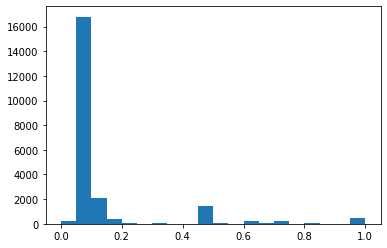

In [24]:
import matplotlib.pyplot as plt

train_proba = label_model.predict_proba(train_L)
plt.hist(train_proba[:, 1], bins=20, range=(0.0, 1.0))
plt.show()

## Part 4: Training our End Extraction Model

In this final section of the tutorial, we'll use our noisy training labels alongside the development set labels to train our end machine learning model. We start by filtering out training examples which did not recieve a label from any LF, as these examples contain no signal. Then we concatenate them with dev set examples.


In [25]:
import pandas as pd
from snorkel.analysis.utils import preds_to_probs

dev_label_probs = preds_to_probs(dev_labels, 2)
mask = train_L.max(1) != -1
combined_df = pd.concat([dev_df, train_df.iloc[mask]])
combined_proba = np.concatenate([dev_label_probs, train_proba[mask, :]], 0)

## II. Training a _Long Short-term Memory_ (LSTM) Neural Network

[LSTMs](https://en.wikipedia.org/wiki/Long_short-term_memory) can acheive state-of-the-art performance on many text classification tasks. We'll train a simple LSTM model below. tf_model contains functions for processing features and building the tensorflow graphs for training and evaluation.

For this tutorial, we will be training a fairly effective deep learning model. More generally, however, Snorkel plugs in with many ML libraries, making it easy to use almost any state-of-the-art model as the end model!

In [26]:
from tf_model import get_features_and_labels, get_model

model = get_model()
tokens, idx1, idx2, label_probs = get_features_and_labels(
    combined_df, combined_proba, tf.float32
)
batch_size = 64
num_epochs = 2  # TODO: Change this to ~10. Warning: Training takes tens of minutes!
model.fit(
    (tokens, idx1, idx2),
    label_probs,
    batch_size=batch_size,
    steps_per_epoch=(len(train_df) // batch_size),
    epochs=num_epochs,
)

W0725 20:39:50.114535 140189862823744 deprecation.py:506] From /home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


W0725 20:39:50.200388 140189862823744 deprecation.py:506] From /home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


W0725 20:39:50.449210 140189862823744 deprecation.py:323] From /home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:3794: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


W0725 20:39:50.485001 140189862823744 deprecation_wrapper.py:119] From /home/ubuntu/snorkel-tutorials/spouse/tf_model.py:46: The name tf.train.AdagradOptimizer is deprecated. Please use tf.compat.v1.train.AdagradOptimizer instead.



W0725 20:39:50.539267 140189862823744 deprecation.py:323] From /home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/data/ops/dataset_ops.py:494: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


W0725 20:39:51.263479 140189862823744 deprecation.py:506] From /home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/training/adagrad.py:76: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/2


  1/347 [..............................] - ETA: 3:46 - loss: 0.6994 - acc: 0.0938

  2/347 [..............................] - ETA: 2:17 - loss: 0.6466 - acc: 0.5312

  3/347 [..............................] - ETA: 1:47 - loss: 0.6061 - acc: 0.6615

  4/347 [..............................] - ETA: 1:32 - loss: 0.5696 - acc: 0.7305

  5/347 [..............................] - ETA: 1:46 - loss: 0.5379 - acc: 0.7719

  6/347 [..............................] - ETA: 1:50 - loss: 0.5155 - acc: 0.7943

  7/347 [..............................] - ETA: 1:53 - loss: 0.4936 - acc: 0.8125

  8/347 [..............................] - ETA: 1:43 - loss: 0.4691 - acc: 0.8301

  9/347 [..............................] - ETA: 1:46 - loss: 0.4522 - acc: 0.8403

 10/347 [..............................] - ETA: 1:39 - loss: 0.4345 - acc: 0.8500

 11/347 [..............................] - ETA: 1:34 - loss: 0.4215 - acc: 0.8565

 12/347 [>.............................] - ETA: 1:29 - loss: 0.4153 - acc: 0.8594

 13/347 [>.............................] - ETA: 1:26 - loss: 0.4100 - acc: 0.8618

 14/347 [>.............................] - ETA: 1:22 - loss: 0.3941 - acc: 0.8694

 15/347 [>.............................] - ETA: 1:19 - loss: 0.3791 - acc: 0.8760

 16/347 [>.............................] - ETA: 1:16 - loss: 0.3750 - acc: 0.8779

 17/347 [>.............................] - ETA: 1:14 - loss: 0.3624 - acc: 0.8833

 18/347 [>.............................] - ETA: 1:11 - loss: 0.3669 - acc: 0.8819

 19/347 [>.............................] - ETA: 1:09 - loss: 0.3584 - acc: 0.8857

 20/347 [>.............................] - ETA: 1:07 - loss: 0.3504 - acc: 0.8891

 21/347 [>.............................] - ETA: 1:05 - loss: 0.3450 - acc: 0.8914

 22/347 [>.............................] - ETA: 1:03 - loss: 0.3382 - acc: 0.8942

 23/347 [>.............................] - ETA: 1:01 - loss: 0.3336 - acc: 0.8961

 24/347 [=>............................] - ETA: 1:00 - loss: 0.3313 - acc: 0.8971

 25/347 [=>............................] - ETA: 59s - loss: 0.3290 - acc: 0.8981 

 26/347 [=>............................] - ETA: 57s - loss: 0.3238 - acc: 0.9002

 27/347 [=>............................] - ETA: 57s - loss: 0.3221 - acc: 0.9010

 28/347 [=>............................] - ETA: 58s - loss: 0.3219 - acc: 0.9012

 29/347 [=>............................] - ETA: 56s - loss: 0.3216 - acc: 0.9014

 30/347 [=>............................] - ETA: 56s - loss: 0.3175 - acc: 0.9031

 31/347 [=>............................] - ETA: 56s - loss: 0.3213 - acc: 0.9017

 32/347 [=>............................] - ETA: 56s - loss: 0.3210 - acc: 0.9019

 33/347 [=>............................] - ETA: 55s - loss: 0.3153 - acc: 0.9044

 34/347 [=>............................] - ETA: 55s - loss: 0.3141 - acc: 0.9049

 35/347 [==>...........................] - ETA: 55s - loss: 0.3119 - acc: 0.9058

 36/347 [==>...........................] - ETA: 54s - loss: 0.3075 - acc: 0.9076

 37/347 [==>...........................] - ETA: 53s - loss: 0.3054 - acc: 0.9084

 38/347 [==>...........................] - ETA: 52s - loss: 0.3001 - acc: 0.9104

 39/347 [==>...........................] - ETA: 52s - loss: 0.3009 - acc: 0.9103

 40/347 [==>...........................] - ETA: 51s - loss: 0.3003 - acc: 0.9105

 41/347 [==>...........................] - ETA: 51s - loss: 0.2966 - acc: 0.9120

 42/347 [==>...........................] - ETA: 50s - loss: 0.2962 - acc: 0.9122

 43/347 [==>...........................] - ETA: 49s - loss: 0.3011 - acc: 0.9106

 44/347 [==>...........................] - ETA: 49s - loss: 0.3126 - acc: 0.9062

 45/347 [==>...........................] - ETA: 49s - loss: 0.3213 - acc: 0.9042

 46/347 [==>...........................] - ETA: 50s - loss: 0.3280 - acc: 0.9025

 47/347 [===>..........................] - ETA: 50s - loss: 0.3360 - acc: 0.8996

 48/347 [===>..........................] - ETA: 50s - loss: 0.3433 - acc: 0.8975

 49/347 [===>..........................] - ETA: 50s - loss: 0.3499 - acc: 0.8948

 50/347 [===>..........................] - ETA: 50s - loss: 0.3565 - acc: 0.8928

 51/347 [===>..........................] - ETA: 50s - loss: 0.3629 - acc: 0.8906

 52/347 [===>..........................] - ETA: 50s - loss: 0.3687 - acc: 0.8882

 53/347 [===>..........................] - ETA: 50s - loss: 0.3749 - acc: 0.8847

 54/347 [===>..........................] - ETA: 50s - loss: 0.3801 - acc: 0.8825

 55/347 [===>..........................] - ETA: 49s - loss: 0.3850 - acc: 0.8807

 56/347 [===>..........................] - ETA: 49s - loss: 0.3890 - acc: 0.8803

 57/347 [===>..........................] - ETA: 49s - loss: 0.3939 - acc: 0.8786

 58/347 [====>.........................] - ETA: 49s - loss: 0.3990 - acc: 0.8763

 59/347 [====>.........................] - ETA: 48s - loss: 0.4037 - acc: 0.8742

 60/347 [====>.........................] - ETA: 48s - loss: 0.4080 - acc: 0.8727

 61/347 [====>.........................] - ETA: 48s - loss: 0.4119 - acc: 0.8709

 62/347 [====>.........................] - ETA: 48s - loss: 0.4157 - acc: 0.8697

 63/347 [====>.........................] - ETA: 48s - loss: 0.4187 - acc: 0.8698

 64/347 [====>.........................] - ETA: 48s - loss: 0.4220 - acc: 0.8691

 65/347 [====>.........................] - ETA: 47s - loss: 0.4257 - acc: 0.8680

 66/347 [====>.........................] - ETA: 47s - loss: 0.4293 - acc: 0.8670

 67/347 [====>.........................] - ETA: 47s - loss: 0.4319 - acc: 0.8671

 68/347 [====>.........................] - ETA: 47s - loss: 0.4348 - acc: 0.8665

 69/347 [====>.........................] - ETA: 46s - loss: 0.4375 - acc: 0.8659

 70/347 [=====>........................] - ETA: 46s - loss: 0.4398 - acc: 0.8665

 71/347 [=====>........................] - ETA: 46s - loss: 0.4422 - acc: 0.8669

 72/347 [=====>........................] - ETA: 46s - loss: 0.4444 - acc: 0.8672

 73/347 [=====>........................] - ETA: 46s - loss: 0.4475 - acc: 0.8654

 74/347 [=====>........................] - ETA: 46s - loss: 0.4504 - acc: 0.8647

 75/347 [=====>........................] - ETA: 46s - loss: 0.4527 - acc: 0.8650

 76/347 [=====>........................] - ETA: 47s - loss: 0.4551 - acc: 0.8643

 77/347 [=====>........................] - ETA: 47s - loss: 0.4572 - acc: 0.8642

 78/347 [=====>........................] - ETA: 47s - loss: 0.4593 - acc: 0.8632

 79/347 [=====>........................] - ETA: 47s - loss: 0.4615 - acc: 0.8621

 80/347 [=====>........................] - ETA: 47s - loss: 0.4639 - acc: 0.8611

 81/347 [======>.......................] - ETA: 46s - loss: 0.4663 - acc: 0.8605

 82/347 [======>.......................] - ETA: 46s - loss: 0.4680 - acc: 0.8611

 83/347 [======>.......................] - ETA: 46s - loss: 0.4704 - acc: 0.8611

 84/347 [======>.......................] - ETA: 46s - loss: 0.4719 - acc: 0.8612

 85/347 [======>.......................] - ETA: 45s - loss: 0.4739 - acc: 0.8608

 86/347 [======>.......................] - ETA: 45s - loss: 0.4762 - acc: 0.8590

 87/347 [======>.......................] - ETA: 45s - loss: 0.4782 - acc: 0.8581

 88/347 [======>.......................] - ETA: 45s - loss: 0.4797 - acc: 0.8581

 89/347 [======>.......................] - ETA: 45s - loss: 0.4812 - acc: 0.8580

 90/347 [======>.......................] - ETA: 45s - loss: 0.4829 - acc: 0.8575

 91/347 [======>.......................] - ETA: 44s - loss: 0.4847 - acc: 0.8570

 92/347 [======>.......................] - ETA: 44s - loss: 0.4858 - acc: 0.8572

 93/347 [=======>......................] - ETA: 44s - loss: 0.4870 - acc: 0.8572

 94/347 [=======>......................] - ETA: 44s - loss: 0.4889 - acc: 0.8562

 95/347 [=======>......................] - ETA: 44s - loss: 0.4906 - acc: 0.8556

 96/347 [=======>......................] - ETA: 44s - loss: 0.4916 - acc: 0.8560

 97/347 [=======>......................] - ETA: 44s - loss: 0.4932 - acc: 0.8558

 98/347 [=======>......................] - ETA: 44s - loss: 0.4953 - acc: 0.8544

 99/347 [=======>......................] - ETA: 43s - loss: 0.4970 - acc: 0.8535

100/347 [=======>......................] - ETA: 43s - loss: 0.4986 - acc: 0.8530

101/347 [=======>......................] - ETA: 43s - loss: 0.4997 - acc: 0.8524

102/347 [=======>......................] - ETA: 44s - loss: 0.5013 - acc: 0.8517

103/347 [=======>......................] - ETA: 43s - loss: 0.5030 - acc: 0.8509

104/347 [=======>......................] - ETA: 44s - loss: 0.5041 - acc: 0.8511

105/347 [========>.....................] - ETA: 43s - loss: 0.5053 - acc: 0.8509

106/347 [========>.....................] - ETA: 44s - loss: 0.5069 - acc: 0.8501

107/347 [========>.....................] - ETA: 43s - loss: 0.5085 - acc: 0.8490

108/347 [========>.....................] - ETA: 43s - loss: 0.5100 - acc: 0.8487

109/347 [========>.....................] - ETA: 43s - loss: 0.5112 - acc: 0.8486

110/347 [========>.....................] - ETA: 43s - loss: 0.5127 - acc: 0.8480

111/347 [========>.....................] - ETA: 43s - loss: 0.5139 - acc: 0.8474

112/347 [========>.....................] - ETA: 43s - loss: 0.5151 - acc: 0.8471

113/347 [========>.....................] - ETA: 43s - loss: 0.5161 - acc: 0.8468

114/347 [========>.....................] - ETA: 42s - loss: 0.5172 - acc: 0.8466

115/347 [========>.....................] - ETA: 42s - loss: 0.5185 - acc: 0.8459

116/347 [=========>....................] - ETA: 42s - loss: 0.5199 - acc: 0.8452

117/347 [=========>....................] - ETA: 42s - loss: 0.5208 - acc: 0.8451

118/347 [=========>....................] - ETA: 41s - loss: 0.5216 - acc: 0.8451

119/347 [=========>....................] - ETA: 41s - loss: 0.5224 - acc: 0.8449

120/347 [=========>....................] - ETA: 41s - loss: 0.5237 - acc: 0.8439

121/347 [=========>....................] - ETA: 41s - loss: 0.5244 - acc: 0.8440

122/347 [=========>....................] - ETA: 40s - loss: 0.5254 - acc: 0.8438

123/347 [=========>....................] - ETA: 40s - loss: 0.5263 - acc: 0.8436

124/347 [=========>....................] - ETA: 40s - loss: 0.5274 - acc: 0.8427

125/347 [=========>....................] - ETA: 39s - loss: 0.5283 - acc: 0.8424

126/347 [=========>....................] - ETA: 39s - loss: 0.5295 - acc: 0.8421

127/347 [=========>....................] - ETA: 39s - loss: 0.5302 - acc: 0.8424

128/347 [==========>...................] - ETA: 39s - loss: 0.5310 - acc: 0.8420

129/347 [==========>...................] - ETA: 38s - loss: 0.5325 - acc: 0.8400

130/347 [==========>...................] - ETA: 38s - loss: 0.5331 - acc: 0.8399

131/347 [==========>...................] - ETA: 38s - loss: 0.5338 - acc: 0.8398

132/347 [==========>...................] - ETA: 38s - loss: 0.5349 - acc: 0.8388

133/347 [==========>...................] - ETA: 38s - loss: 0.5356 - acc: 0.8387

134/347 [==========>...................] - ETA: 37s - loss: 0.5358 - acc: 0.8387

135/347 [==========>...................] - ETA: 37s - loss: 0.5353 - acc: 0.8392

136/347 [==========>...................] - ETA: 37s - loss: 0.5341 - acc: 0.8403

137/347 [==========>...................] - ETA: 37s - loss: 0.5328 - acc: 0.8411

138/347 [==========>...................] - ETA: 37s - loss: 0.5313 - acc: 0.8419

139/347 [===========>..................] - ETA: 37s - loss: 0.5296 - acc: 0.8427

140/347 [===========>..................] - ETA: 37s - loss: 0.5284 - acc: 0.8431

141/347 [===========>..................] - ETA: 37s - loss: 0.5266 - acc: 0.8439

142/347 [===========>..................] - ETA: 37s - loss: 0.5246 - acc: 0.8446

143/347 [===========>..................] - ETA: 37s - loss: 0.5229 - acc: 0.8452

144/347 [===========>..................] - ETA: 37s - loss: 0.5210 - acc: 0.8458

145/347 [===========>..................] - ETA: 37s - loss: 0.5203 - acc: 0.8459

146/347 [===========>..................] - ETA: 36s - loss: 0.5187 - acc: 0.8464

147/347 [===========>..................] - ETA: 36s - loss: 0.5173 - acc: 0.8468

148/347 [===========>..................] - ETA: 36s - loss: 0.5154 - acc: 0.8474

149/347 [===========>..................] - ETA: 36s - loss: 0.5133 - acc: 0.8482

150/347 [===========>..................] - ETA: 35s - loss: 0.5113 - acc: 0.8489

151/347 [============>.................] - ETA: 35s - loss: 0.5094 - acc: 0.8494

152/347 [============>.................] - ETA: 35s - loss: 0.5084 - acc: 0.8497

153/347 [============>.................] - ETA: 34s - loss: 0.5069 - acc: 0.8502

154/347 [============>.................] - ETA: 34s - loss: 0.5049 - acc: 0.8509

155/347 [============>.................] - ETA: 34s - loss: 0.5036 - acc: 0.8512

156/347 [============>.................] - ETA: 34s - loss: 0.5019 - acc: 0.8518

157/347 [============>.................] - ETA: 33s - loss: 0.5007 - acc: 0.8521

158/347 [============>.................] - ETA: 33s - loss: 0.4988 - acc: 0.8527

159/347 [============>.................] - ETA: 33s - loss: 0.4969 - acc: 0.8534

160/347 [============>.................] - ETA: 33s - loss: 0.4958 - acc: 0.8537

161/347 [============>.................] - ETA: 32s - loss: 0.4949 - acc: 0.8539

162/347 [=============>................] - ETA: 32s - loss: 0.4935 - acc: 0.8544

163/347 [=============>................] - ETA: 32s - loss: 0.4915 - acc: 0.8551

164/347 [=============>................] - ETA: 32s - loss: 0.4902 - acc: 0.8555

165/347 [=============>................] - ETA: 32s - loss: 0.4886 - acc: 0.8560

166/347 [=============>................] - ETA: 32s - loss: 0.4878 - acc: 0.8562

167/347 [=============>................] - ETA: 31s - loss: 0.4858 - acc: 0.8568

168/347 [=============>................] - ETA: 31s - loss: 0.4839 - acc: 0.8575

169/347 [=============>................] - ETA: 31s - loss: 0.4821 - acc: 0.8581

170/347 [=============>................] - ETA: 31s - loss: 0.4809 - acc: 0.8585

171/347 [=============>................] - ETA: 31s - loss: 0.4797 - acc: 0.8588

172/347 [=============>................] - ETA: 30s - loss: 0.4783 - acc: 0.8593

173/347 [=============>................] - ETA: 30s - loss: 0.4769 - acc: 0.8597

174/347 [==============>...............] - ETA: 30s - loss: 0.4755 - acc: 0.8602

175/347 [==============>...............] - ETA: 30s - loss: 0.4741 - acc: 0.8606

176/347 [==============>...............] - ETA: 29s - loss: 0.4731 - acc: 0.8610

177/347 [==============>...............] - ETA: 29s - loss: 0.4735 - acc: 0.8609

178/347 [==============>...............] - ETA: 29s - loss: 0.4752 - acc: 0.8603

179/347 [==============>...............] - ETA: 29s - loss: 0.4769 - acc: 0.8597

180/347 [==============>...............] - ETA: 29s - loss: 0.4783 - acc: 0.8592

181/347 [==============>...............] - ETA: 29s - loss: 0.4795 - acc: 0.8589

182/347 [==============>...............] - ETA: 28s - loss: 0.4803 - acc: 0.8588

183/347 [==============>...............] - ETA: 28s - loss: 0.4816 - acc: 0.8584

184/347 [==============>...............] - ETA: 28s - loss: 0.4827 - acc: 0.8580

185/347 [==============>...............] - ETA: 28s - loss: 0.4840 - acc: 0.8572

186/347 [===============>..............] - ETA: 28s - loss: 0.4850 - acc: 0.8566

187/347 [===============>..............] - ETA: 28s - loss: 0.4860 - acc: 0.8559

188/347 [===============>..............] - ETA: 27s - loss: 0.4869 - acc: 0.8557

189/347 [===============>..............] - ETA: 27s - loss: 0.4879 - acc: 0.8552

190/347 [===============>..............] - ETA: 27s - loss: 0.4886 - acc: 0.8549

191/347 [===============>..............] - ETA: 27s - loss: 0.4894 - acc: 0.8547

192/347 [===============>..............] - ETA: 27s - loss: 0.4906 - acc: 0.8539

193/347 [===============>..............] - ETA: 26s - loss: 0.4916 - acc: 0.8532

194/347 [===============>..............] - ETA: 26s - loss: 0.4925 - acc: 0.8527

195/347 [===============>..............] - ETA: 26s - loss: 0.4932 - acc: 0.8529

196/347 [===============>..............] - ETA: 26s - loss: 0.4940 - acc: 0.8526

197/347 [================>.............] - ETA: 26s - loss: 0.4945 - acc: 0.8527

198/347 [================>.............] - ETA: 26s - loss: 0.4951 - acc: 0.8527

199/347 [================>.............] - ETA: 25s - loss: 0.4961 - acc: 0.8525

200/347 [================>.............] - ETA: 25s - loss: 0.4970 - acc: 0.8517

201/347 [================>.............] - ETA: 25s - loss: 0.4975 - acc: 0.8518

202/347 [================>.............] - ETA: 25s - loss: 0.4982 - acc: 0.8516

203/347 [================>.............] - ETA: 25s - loss: 0.4988 - acc: 0.8518

204/347 [================>.............] - ETA: 25s - loss: 0.4995 - acc: 0.8516

205/347 [================>.............] - ETA: 24s - loss: 0.4999 - acc: 0.8518

206/347 [================>.............] - ETA: 24s - loss: 0.5006 - acc: 0.8518

207/347 [================>.............] - ETA: 24s - loss: 0.5011 - acc: 0.8519

208/347 [================>.............] - ETA: 24s - loss: 0.5018 - acc: 0.8518

209/347 [=================>............] - ETA: 24s - loss: 0.5023 - acc: 0.8521

210/347 [=================>............] - ETA: 24s - loss: 0.5029 - acc: 0.8520

211/347 [=================>............] - ETA: 23s - loss: 0.5035 - acc: 0.8516

212/347 [=================>............] - ETA: 24s - loss: 0.5042 - acc: 0.8510

213/347 [=================>............] - ETA: 23s - loss: 0.5047 - acc: 0.8512

214/347 [=================>............] - ETA: 23s - loss: 0.5054 - acc: 0.8508

215/347 [=================>............] - ETA: 23s - loss: 0.5059 - acc: 0.8509

216/347 [=================>............] - ETA: 23s - loss: 0.5064 - acc: 0.8510

217/347 [=================>............] - ETA: 23s - loss: 0.5073 - acc: 0.8506

218/347 [=================>............] - ETA: 22s - loss: 0.5080 - acc: 0.8501

219/347 [=================>............] - ETA: 22s - loss: 0.5085 - acc: 0.8505

220/347 [==================>...........] - ETA: 22s - loss: 0.5089 - acc: 0.8506

221/347 [==================>...........] - ETA: 22s - loss: 0.5095 - acc: 0.8503

222/347 [==================>...........] - ETA: 22s - loss: 0.5101 - acc: 0.8502

223/347 [==================>...........] - ETA: 21s - loss: 0.5107 - acc: 0.8498

224/347 [==================>...........] - ETA: 21s - loss: 0.5112 - acc: 0.8499

225/347 [==================>...........] - ETA: 21s - loss: 0.5115 - acc: 0.8498

226/347 [==================>...........] - ETA: 21s - loss: 0.5119 - acc: 0.8499

227/347 [==================>...........] - ETA: 21s - loss: 0.5125 - acc: 0.8499

228/347 [==================>...........] - ETA: 21s - loss: 0.5129 - acc: 0.8499

229/347 [==================>...........] - ETA: 20s - loss: 0.5135 - acc: 0.8495

230/347 [==================>...........] - ETA: 20s - loss: 0.5140 - acc: 0.8495

231/347 [==================>...........] - ETA: 20s - loss: 0.5146 - acc: 0.8493

232/347 [===================>..........] - ETA: 20s - loss: 0.5154 - acc: 0.8487

233/347 [===================>..........] - ETA: 20s - loss: 0.5161 - acc: 0.8486

234/347 [===================>..........] - ETA: 19s - loss: 0.5166 - acc: 0.8483

235/347 [===================>..........] - ETA: 19s - loss: 0.5171 - acc: 0.8481

236/347 [===================>..........] - ETA: 19s - loss: 0.5179 - acc: 0.8472

237/347 [===================>..........] - ETA: 19s - loss: 0.5185 - acc: 0.8469

238/347 [===================>..........] - ETA: 19s - loss: 0.5188 - acc: 0.8472

239/347 [===================>..........] - ETA: 19s - loss: 0.5192 - acc: 0.8473

240/347 [===================>..........] - ETA: 19s - loss: 0.5199 - acc: 0.8468

241/347 [===================>..........] - ETA: 19s - loss: 0.5205 - acc: 0.8467

242/347 [===================>..........] - ETA: 18s - loss: 0.5211 - acc: 0.8463

243/347 [====================>.........] - ETA: 18s - loss: 0.5217 - acc: 0.8461

244/347 [====================>.........] - ETA: 18s - loss: 0.5224 - acc: 0.8458

245/347 [====================>.........] - ETA: 18s - loss: 0.5229 - acc: 0.8455

246/347 [====================>.........] - ETA: 18s - loss: 0.5233 - acc: 0.8455

247/347 [====================>.........] - ETA: 17s - loss: 0.5237 - acc: 0.8455

248/347 [====================>.........] - ETA: 17s - loss: 0.5241 - acc: 0.8456

249/347 [====================>.........] - ETA: 17s - loss: 0.5247 - acc: 0.8453

250/347 [====================>.........] - ETA: 17s - loss: 0.5253 - acc: 0.8450

251/347 [====================>.........] - ETA: 17s - loss: 0.5257 - acc: 0.8451

252/347 [====================>.........] - ETA: 17s - loss: 0.5261 - acc: 0.8447

253/347 [====================>.........] - ETA: 16s - loss: 0.5266 - acc: 0.8446

254/347 [====================>.........] - ETA: 16s - loss: 0.5270 - acc: 0.8444

255/347 [=====================>........] - ETA: 16s - loss: 0.5274 - acc: 0.8444

256/347 [=====================>........] - ETA: 16s - loss: 0.5277 - acc: 0.8444

257/347 [=====================>........] - ETA: 16s - loss: 0.5282 - acc: 0.8444

258/347 [=====================>........] - ETA: 15s - loss: 0.5287 - acc: 0.8441

259/347 [=====================>........] - ETA: 15s - loss: 0.5292 - acc: 0.8438

260/347 [=====================>........] - ETA: 15s - loss: 0.5298 - acc: 0.8434

261/347 [=====================>........] - ETA: 15s - loss: 0.5302 - acc: 0.8431

262/347 [=====================>........] - ETA: 15s - loss: 0.5307 - acc: 0.8426

263/347 [=====================>........] - ETA: 14s - loss: 0.5311 - acc: 0.8426

264/347 [=====================>........] - ETA: 14s - loss: 0.5316 - acc: 0.8421

265/347 [=====================>........] - ETA: 14s - loss: 0.5318 - acc: 0.8423

266/347 [=====================>........] - ETA: 14s - loss: 0.5323 - acc: 0.8418

267/347 [======================>.......] - ETA: 14s - loss: 0.5328 - acc: 0.8416

268/347 [======================>.......] - ETA: 13s - loss: 0.5327 - acc: 0.8418

269/347 [======================>.......] - ETA: 13s - loss: 0.5323 - acc: 0.8422

270/347 [======================>.......] - ETA: 13s - loss: 0.5317 - acc: 0.8427

271/347 [======================>.......] - ETA: 13s - loss: 0.5311 - acc: 0.8430

272/347 [======================>.......] - ETA: 13s - loss: 0.5307 - acc: 0.8432

273/347 [======================>.......] - ETA: 13s - loss: 0.5298 - acc: 0.8436

274/347 [======================>.......] - ETA: 13s - loss: 0.5292 - acc: 0.8439

275/347 [======================>.......] - ETA: 12s - loss: 0.5283 - acc: 0.8443

276/347 [======================>.......] - ETA: 12s - loss: 0.5275 - acc: 0.8445

277/347 [======================>.......] - ETA: 12s - loss: 0.5263 - acc: 0.8450

278/347 [=======================>......] - ETA: 12s - loss: 0.5255 - acc: 0.8453

279/347 [=======================>......] - ETA: 12s - loss: 0.5247 - acc: 0.8455

280/347 [=======================>......] - ETA: 12s - loss: 0.5235 - acc: 0.8460

281/347 [=======================>......] - ETA: 11s - loss: 0.5231 - acc: 0.8460

282/347 [=======================>......] - ETA: 11s - loss: 0.5220 - acc: 0.8464

283/347 [=======================>......] - ETA: 11s - loss: 0.5211 - acc: 0.8467

284/347 [=======================>......] - ETA: 11s - loss: 0.5199 - acc: 0.8471

285/347 [=======================>......] - ETA: 11s - loss: 0.5189 - acc: 0.8474

286/347 [=======================>......] - ETA: 10s - loss: 0.5186 - acc: 0.8475

287/347 [=======================>......] - ETA: 10s - loss: 0.5177 - acc: 0.8477

288/347 [=======================>......] - ETA: 10s - loss: 0.5169 - acc: 0.8480

289/347 [=======================>......] - ETA: 10s - loss: 0.5157 - acc: 0.8484

290/347 [========================>.....] - ETA: 10s - loss: 0.5144 - acc: 0.8488

291/347 [========================>.....] - ETA: 9s - loss: 0.5138 - acc: 0.8490 

292/347 [========================>.....] - ETA: 9s - loss: 0.5127 - acc: 0.8494

293/347 [========================>.....] - ETA: 9s - loss: 0.5119 - acc: 0.8496

294/347 [========================>.....] - ETA: 9s - loss: 0.5112 - acc: 0.8498

295/347 [========================>.....] - ETA: 9s - loss: 0.5107 - acc: 0.8499

296/347 [========================>.....] - ETA: 8s - loss: 0.5101 - acc: 0.8501

297/347 [========================>.....] - ETA: 8s - loss: 0.5092 - acc: 0.8504

298/347 [========================>.....] - ETA: 8s - loss: 0.5084 - acc: 0.8506

299/347 [========================>.....] - ETA: 8s - loss: 0.5077 - acc: 0.8508

300/347 [========================>.....] - ETA: 8s - loss: 0.5066 - acc: 0.8512

301/347 [=========================>....] - ETA: 8s - loss: 0.5054 - acc: 0.8516

302/347 [=========================>....] - ETA: 7s - loss: 0.5049 - acc: 0.8517

303/347 [=========================>....] - ETA: 7s - loss: 0.5038 - acc: 0.8521

304/347 [=========================>....] - ETA: 7s - loss: 0.5028 - acc: 0.8524

305/347 [=========================>....] - ETA: 7s - loss: 0.5017 - acc: 0.8528

306/347 [=========================>....] - ETA: 7s - loss: 0.5009 - acc: 0.8530

307/347 [=========================>....] - ETA: 6s - loss: 0.5000 - acc: 0.8533

308/347 [=========================>....] - ETA: 6s - loss: 0.4988 - acc: 0.8537

309/347 [=========================>....] - ETA: 6s - loss: 0.4980 - acc: 0.8540

310/347 [=========================>....] - ETA: 6s - loss: 0.4984 - acc: 0.8539

311/347 [=========================>....] - ETA: 6s - loss: 0.4988 - acc: 0.8537

312/347 [=========================>....] - ETA: 6s - loss: 0.4997 - acc: 0.8535

313/347 [==========================>...] - ETA: 5s - loss: 0.5004 - acc: 0.8533

314/347 [==========================>...] - ETA: 5s - loss: 0.5010 - acc: 0.8531

315/347 [==========================>...] - ETA: 5s - loss: 0.5016 - acc: 0.8528

316/347 [==========================>...] - ETA: 5s - loss: 0.5020 - acc: 0.8529

317/347 [==========================>...] - ETA: 5s - loss: 0.5027 - acc: 0.8526

318/347 [==========================>...] - ETA: 5s - loss: 0.5034 - acc: 0.8522

319/347 [==========================>...] - ETA: 4s - loss: 0.5040 - acc: 0.8520

320/347 [==========================>...] - ETA: 4s - loss: 0.5048 - acc: 0.8513

321/347 [==========================>...] - ETA: 4s - loss: 0.5052 - acc: 0.8511

322/347 [==========================>...] - ETA: 4s - loss: 0.5058 - acc: 0.8509

323/347 [==========================>...] - ETA: 4s - loss: 0.5061 - acc: 0.8510

324/347 [===========================>..] - ETA: 4s - loss: 0.5067 - acc: 0.8506

325/347 [===========================>..] - ETA: 3s - loss: 0.5073 - acc: 0.8501

326/347 [===========================>..] - ETA: 3s - loss: 0.5078 - acc: 0.8499

327/347 [===========================>..] - ETA: 3s - loss: 0.5082 - acc: 0.8498

328/347 [===========================>..] - ETA: 3s - loss: 0.5086 - acc: 0.8497

329/347 [===========================>..] - ETA: 3s - loss: 0.5090 - acc: 0.8496

330/347 [===========================>..] - ETA: 2s - loss: 0.5093 - acc: 0.8496

331/347 [===========================>..] - ETA: 2s - loss: 0.5097 - acc: 0.8494

332/347 [===========================>..] - ETA: 2s - loss: 0.5102 - acc: 0.8493

333/347 [===========================>..] - ETA: 2s - loss: 0.5106 - acc: 0.8493

334/347 [===========================>..] - ETA: 2s - loss: 0.5111 - acc: 0.8490

335/347 [===========================>..] - ETA: 2s - loss: 0.5114 - acc: 0.8489

336/347 [============================>.] - ETA: 1s - loss: 0.5117 - acc: 0.8489

337/347 [============================>.] - ETA: 1s - loss: 0.5121 - acc: 0.8491

338/347 [============================>.] - ETA: 1s - loss: 0.5124 - acc: 0.8492

339/347 [============================>.] - ETA: 1s - loss: 0.5126 - acc: 0.8491

340/347 [============================>.] - ETA: 1s - loss: 0.5130 - acc: 0.8490

341/347 [============================>.] - ETA: 1s - loss: 0.5133 - acc: 0.8492

342/347 [============================>.] - ETA: 0s - loss: 0.5136 - acc: 0.8494

343/347 [============================>.] - ETA: 0s - loss: 0.5139 - acc: 0.8493

344/347 [============================>.] - ETA: 0s - loss: 0.5142 - acc: 0.8492

345/347 [============================>.] - ETA: 0s - loss: 0.5146 - acc: 0.8489

346/347 [============================>.] - ETA: 0s - loss: 0.5150 - acc: 0.8485

347/347 [==============================] - 61s 175ms/step - loss: 0.5153 - acc: 0.8485


Epoch 2/2


  1/347 [..............................] - ETA: 1:54 - loss: 0.6281 - acc: 0.8281

  2/347 [..............................] - ETA: 1:21 - loss: 0.6241 - acc: 0.8594

  3/347 [..............................] - ETA: 1:05 - loss: 0.6494 - acc: 0.8229

  4/347 [..............................] - ETA: 58s - loss: 0.6577 - acc: 0.8203 

  5/347 [..............................] - ETA: 54s - loss: 0.6465 - acc: 0.8313

  6/347 [..............................] - ETA: 52s - loss: 0.6443 - acc: 0.8255

  7/347 [..............................] - ETA: 51s - loss: 0.6401 - acc: 0.8281

  8/347 [..............................] - ETA: 55s - loss: 0.6379 - acc: 0.8320

  9/347 [..............................] - ETA: 53s - loss: 0.6367 - acc: 0.8333

 10/347 [..............................] - ETA: 56s - loss: 0.6386 - acc: 0.8234

 11/347 [..............................] - ETA: 54s - loss: 0.6364 - acc: 0.8281

 12/347 [>.............................] - ETA: 57s - loss: 0.6320 - acc: 0.8320

 13/347 [>.............................] - ETA: 55s - loss: 0.6302 - acc: 0.8341

 14/347 [>.............................] - ETA: 56s - loss: 0.6286 - acc: 0.8348

 15/347 [>.............................] - ETA: 57s - loss: 0.6281 - acc: 0.8344

 16/347 [>.............................] - ETA: 59s - loss: 0.6294 - acc: 0.8311

 17/347 [>.............................] - ETA: 1:00 - loss: 0.6328 - acc: 0.8244

 18/347 [>.............................] - ETA: 59s - loss: 0.6356 - acc: 0.8238 

 19/347 [>.............................] - ETA: 58s - loss: 0.6369 - acc: 0.8224

 20/347 [>.............................] - ETA: 58s - loss: 0.6367 - acc: 0.8234

 21/347 [>.............................] - ETA: 58s - loss: 0.6374 - acc: 0.8207

 22/347 [>.............................] - ETA: 1:00 - loss: 0.6365 - acc: 0.8203

 23/347 [>.............................] - ETA: 1:03 - loss: 0.6375 - acc: 0.8179

 24/347 [=>............................] - ETA: 1:03 - loss: 0.6377 - acc: 0.8171

 25/347 [=>............................] - ETA: 1:05 - loss: 0.6373 - acc: 0.8169

 26/347 [=>............................] - ETA: 1:05 - loss: 0.6390 - acc: 0.8143

 27/347 [=>............................] - ETA: 1:05 - loss: 0.6406 - acc: 0.8113

 28/347 [=>............................] - ETA: 1:05 - loss: 0.6416 - acc: 0.8114

 29/347 [=>............................] - ETA: 1:05 - loss: 0.6430 - acc: 0.8087

 30/347 [=>............................] - ETA: 1:04 - loss: 0.6437 - acc: 0.8099

 31/347 [=>............................] - ETA: 1:04 - loss: 0.6439 - acc: 0.8110

 32/347 [=>............................] - ETA: 1:04 - loss: 0.6433 - acc: 0.8120

 33/347 [=>............................] - ETA: 1:04 - loss: 0.6427 - acc: 0.8125

 34/347 [=>............................] - ETA: 1:03 - loss: 0.6420 - acc: 0.8139

 35/347 [==>...........................] - ETA: 1:02 - loss: 0.6437 - acc: 0.8112

 36/347 [==>...........................] - ETA: 1:02 - loss: 0.6427 - acc: 0.8129

 37/347 [==>...........................] - ETA: 1:01 - loss: 0.6422 - acc: 0.8125

 38/347 [==>...........................] - ETA: 1:01 - loss: 0.6427 - acc: 0.8096

 39/347 [==>...........................] - ETA: 1:00 - loss: 0.6423 - acc: 0.8097

 40/347 [==>...........................] - ETA: 1:00 - loss: 0.6426 - acc: 0.8105

 41/347 [==>...........................] - ETA: 59s - loss: 0.6425 - acc: 0.8098 

 42/347 [==>...........................] - ETA: 58s - loss: 0.6424 - acc: 0.8103

 43/347 [==>...........................] - ETA: 57s - loss: 0.6412 - acc: 0.8121

 44/347 [==>...........................] - ETA: 57s - loss: 0.6420 - acc: 0.8118

 45/347 [==>...........................] - ETA: 56s - loss: 0.6424 - acc: 0.8104

 46/347 [==>...........................] - ETA: 56s - loss: 0.6424 - acc: 0.8105

 47/347 [===>..........................] - ETA: 55s - loss: 0.6427 - acc: 0.8098

 48/347 [===>..........................] - ETA: 55s - loss: 0.6435 - acc: 0.8079

 49/347 [===>..........................] - ETA: 54s - loss: 0.6434 - acc: 0.8068

 50/347 [===>..........................] - ETA: 54s - loss: 0.6433 - acc: 0.8069

 51/347 [===>..........................] - ETA: 53s - loss: 0.6435 - acc: 0.8061

 52/347 [===>..........................] - ETA: 53s - loss: 0.6436 - acc: 0.8050

 53/347 [===>..........................] - ETA: 53s - loss: 0.6437 - acc: 0.8040

 54/347 [===>..........................] - ETA: 52s - loss: 0.6420 - acc: 0.8058

 55/347 [===>..........................] - ETA: 52s - loss: 0.6387 - acc: 0.8080

 56/347 [===>..........................] - ETA: 51s - loss: 0.6351 - acc: 0.8100

 57/347 [===>..........................] - ETA: 52s - loss: 0.6317 - acc: 0.8114

 58/347 [====>.........................] - ETA: 53s - loss: 0.6269 - acc: 0.8141

 59/347 [====>.........................] - ETA: 53s - loss: 0.6221 - acc: 0.8165

 60/347 [====>.........................] - ETA: 54s - loss: 0.6180 - acc: 0.8180

 61/347 [====>.........................] - ETA: 54s - loss: 0.6136 - acc: 0.8197

 62/347 [====>.........................] - ETA: 53s - loss: 0.6087 - acc: 0.8216

 63/347 [====>.........................] - ETA: 53s - loss: 0.6038 - acc: 0.8234

 64/347 [====>.........................] - ETA: 52s - loss: 0.5989 - acc: 0.8252

 65/347 [====>.........................] - ETA: 52s - loss: 0.5944 - acc: 0.8267

 66/347 [====>.........................] - ETA: 51s - loss: 0.5899 - acc: 0.8281

 67/347 [====>.........................] - ETA: 51s - loss: 0.5855 - acc: 0.8295

 68/347 [====>.........................] - ETA: 50s - loss: 0.5811 - acc: 0.8309

 69/347 [====>.........................] - ETA: 50s - loss: 0.5773 - acc: 0.8320

 70/347 [=====>........................] - ETA: 49s - loss: 0.5709 - acc: 0.8344

 71/347 [=====>........................] - ETA: 49s - loss: 0.5662 - acc: 0.8358

 72/347 [=====>........................] - ETA: 48s - loss: 0.5641 - acc: 0.8362

 73/347 [=====>........................] - ETA: 48s - loss: 0.5597 - acc: 0.8375

 74/347 [=====>........................] - ETA: 48s - loss: 0.5545 - acc: 0.8393

 75/347 [=====>........................] - ETA: 47s - loss: 0.5507 - acc: 0.8404

 76/347 [=====>........................] - ETA: 47s - loss: 0.5466 - acc: 0.8417

 77/347 [=====>........................] - ETA: 46s - loss: 0.5425 - acc: 0.8429

 78/347 [=====>........................] - ETA: 46s - loss: 0.5371 - acc: 0.8448

 79/347 [=====>........................] - ETA: 45s - loss: 0.5333 - acc: 0.8459

 80/347 [=====>........................] - ETA: 45s - loss: 0.5316 - acc: 0.8463

 81/347 [======>.......................] - ETA: 45s - loss: 0.5284 - acc: 0.8472

 82/347 [======>.......................] - ETA: 45s - loss: 0.5248 - acc: 0.8483

 83/347 [======>.......................] - ETA: 44s - loss: 0.5227 - acc: 0.8488

 84/347 [======>.......................] - ETA: 44s - loss: 0.5202 - acc: 0.8495

 85/347 [======>.......................] - ETA: 44s - loss: 0.5173 - acc: 0.8504

 86/347 [======>.......................] - ETA: 44s - loss: 0.5132 - acc: 0.8517

 87/347 [======>.......................] - ETA: 44s - loss: 0.5091 - acc: 0.8531

 88/347 [======>.......................] - ETA: 44s - loss: 0.5060 - acc: 0.8540

 89/347 [======>.......................] - ETA: 43s - loss: 0.5024 - acc: 0.8552

 90/347 [======>.......................] - ETA: 43s - loss: 0.4985 - acc: 0.8564

 91/347 [======>.......................] - ETA: 43s - loss: 0.4970 - acc: 0.8568

 92/347 [======>.......................] - ETA: 42s - loss: 0.4933 - acc: 0.8580

 93/347 [=======>......................] - ETA: 42s - loss: 0.4896 - acc: 0.8592

 94/347 [=======>......................] - ETA: 41s - loss: 0.4868 - acc: 0.8600

 95/347 [=======>......................] - ETA: 41s - loss: 0.4860 - acc: 0.8602

 96/347 [=======>......................] - ETA: 41s - loss: 0.4839 - acc: 0.8608

 97/347 [=======>......................] - ETA: 41s - loss: 0.4844 - acc: 0.8607

 98/347 [=======>......................] - ETA: 41s - loss: 0.4890 - acc: 0.8592

 99/347 [=======>......................] - ETA: 41s - loss: 0.4914 - acc: 0.8587

100/347 [=======>......................] - ETA: 40s - loss: 0.4937 - acc: 0.8580

101/347 [=======>......................] - ETA: 40s - loss: 0.4960 - acc: 0.8574

102/347 [=======>......................] - ETA: 40s - loss: 0.4977 - acc: 0.8569

103/347 [=======>......................] - ETA: 40s - loss: 0.4999 - acc: 0.8560

104/347 [=======>......................] - ETA: 40s - loss: 0.5014 - acc: 0.8556

105/347 [========>.....................] - ETA: 40s - loss: 0.5034 - acc: 0.8545

106/347 [========>.....................] - ETA: 40s - loss: 0.5051 - acc: 0.8533

107/347 [========>.....................] - ETA: 40s - loss: 0.5070 - acc: 0.8519

108/347 [========>.....................] - ETA: 40s - loss: 0.5085 - acc: 0.8514

109/347 [========>.....................] - ETA: 40s - loss: 0.5100 - acc: 0.8511

110/347 [========>.....................] - ETA: 39s - loss: 0.5117 - acc: 0.8501

111/347 [========>.....................] - ETA: 39s - loss: 0.5131 - acc: 0.8492

112/347 [========>.....................] - ETA: 39s - loss: 0.5149 - acc: 0.8479

113/347 [========>.....................] - ETA: 39s - loss: 0.5163 - acc: 0.8475

114/347 [========>.....................] - ETA: 38s - loss: 0.5177 - acc: 0.8470

115/347 [========>.....................] - ETA: 38s - loss: 0.5184 - acc: 0.8470

116/347 [=========>....................] - ETA: 38s - loss: 0.5196 - acc: 0.8464

117/347 [=========>....................] - ETA: 38s - loss: 0.5204 - acc: 0.8462

118/347 [=========>....................] - ETA: 38s - loss: 0.5212 - acc: 0.8465

119/347 [=========>....................] - ETA: 38s - loss: 0.5229 - acc: 0.8455

120/347 [=========>....................] - ETA: 38s - loss: 0.5237 - acc: 0.8456

121/347 [=========>....................] - ETA: 37s - loss: 0.5246 - acc: 0.8453

122/347 [=========>....................] - ETA: 37s - loss: 0.5255 - acc: 0.8452

123/347 [=========>....................] - ETA: 37s - loss: 0.5262 - acc: 0.8454

124/347 [=========>....................] - ETA: 37s - loss: 0.5270 - acc: 0.8459

125/347 [=========>....................] - ETA: 36s - loss: 0.5276 - acc: 0.8459

126/347 [=========>....................] - ETA: 36s - loss: 0.5282 - acc: 0.8457

127/347 [=========>....................] - ETA: 36s - loss: 0.5289 - acc: 0.8456

128/347 [==========>...................] - ETA: 36s - loss: 0.5299 - acc: 0.8455

129/347 [==========>...................] - ETA: 36s - loss: 0.5307 - acc: 0.8456

130/347 [==========>...................] - ETA: 36s - loss: 0.5313 - acc: 0.8460

131/347 [==========>...................] - ETA: 36s - loss: 0.5319 - acc: 0.8458

132/347 [==========>...................] - ETA: 36s - loss: 0.5329 - acc: 0.8448

133/347 [==========>...................] - ETA: 36s - loss: 0.5338 - acc: 0.8440

134/347 [==========>...................] - ETA: 36s - loss: 0.5345 - acc: 0.8440

135/347 [==========>...................] - ETA: 36s - loss: 0.5350 - acc: 0.8441

136/347 [==========>...................] - ETA: 35s - loss: 0.5360 - acc: 0.8440

137/347 [==========>...................] - ETA: 35s - loss: 0.5369 - acc: 0.8439

138/347 [==========>...................] - ETA: 35s - loss: 0.5380 - acc: 0.8431

139/347 [===========>..................] - ETA: 35s - loss: 0.5385 - acc: 0.8436

140/347 [===========>..................] - ETA: 34s - loss: 0.5390 - acc: 0.8436

141/347 [===========>..................] - ETA: 34s - loss: 0.5395 - acc: 0.8439

142/347 [===========>..................] - ETA: 34s - loss: 0.5399 - acc: 0.8441

143/347 [===========>..................] - ETA: 34s - loss: 0.5404 - acc: 0.8442

144/347 [===========>..................] - ETA: 34s - loss: 0.5410 - acc: 0.8439

145/347 [===========>..................] - ETA: 34s - loss: 0.5414 - acc: 0.8441

146/347 [===========>..................] - ETA: 34s - loss: 0.5420 - acc: 0.8441

147/347 [===========>..................] - ETA: 34s - loss: 0.5427 - acc: 0.8438

148/347 [===========>..................] - ETA: 34s - loss: 0.5430 - acc: 0.8436

149/347 [===========>..................] - ETA: 34s - loss: 0.5439 - acc: 0.8431

150/347 [===========>..................] - ETA: 34s - loss: 0.5449 - acc: 0.8425

151/347 [============>.................] - ETA: 33s - loss: 0.5458 - acc: 0.8421

152/347 [============>.................] - ETA: 33s - loss: 0.5465 - acc: 0.8417

153/347 [============>.................] - ETA: 33s - loss: 0.5469 - acc: 0.8418

154/347 [============>.................] - ETA: 33s - loss: 0.5477 - acc: 0.8412

155/347 [============>.................] - ETA: 33s - loss: 0.5482 - acc: 0.8409

156/347 [============>.................] - ETA: 33s - loss: 0.5489 - acc: 0.8406

157/347 [============>.................] - ETA: 33s - loss: 0.5496 - acc: 0.8401

158/347 [============>.................] - ETA: 33s - loss: 0.5501 - acc: 0.8401

159/347 [============>.................] - ETA: 33s - loss: 0.5507 - acc: 0.8398

160/347 [============>.................] - ETA: 33s - loss: 0.5515 - acc: 0.8393

161/347 [============>.................] - ETA: 32s - loss: 0.5522 - acc: 0.8391

162/347 [=============>................] - ETA: 32s - loss: 0.5529 - acc: 0.8390

163/347 [=============>................] - ETA: 32s - loss: 0.5536 - acc: 0.8391

164/347 [=============>................] - ETA: 32s - loss: 0.5543 - acc: 0.8385

165/347 [=============>................] - ETA: 32s - loss: 0.5548 - acc: 0.8384

166/347 [=============>................] - ETA: 32s - loss: 0.5551 - acc: 0.8386

167/347 [=============>................] - ETA: 31s - loss: 0.5555 - acc: 0.8386

168/347 [=============>................] - ETA: 31s - loss: 0.5562 - acc: 0.8381

169/347 [=============>................] - ETA: 31s - loss: 0.5568 - acc: 0.8378

170/347 [=============>................] - ETA: 31s - loss: 0.5575 - acc: 0.8371

171/347 [=============>................] - ETA: 31s - loss: 0.5580 - acc: 0.8367

172/347 [=============>................] - ETA: 30s - loss: 0.5583 - acc: 0.8370

173/347 [=============>................] - ETA: 30s - loss: 0.5584 - acc: 0.8375

174/347 [==============>...............] - ETA: 30s - loss: 0.5592 - acc: 0.8368

175/347 [==============>...............] - ETA: 30s - loss: 0.5594 - acc: 0.8368

176/347 [==============>...............] - ETA: 29s - loss: 0.5600 - acc: 0.8367

177/347 [==============>...............] - ETA: 29s - loss: 0.5605 - acc: 0.8364

178/347 [==============>...............] - ETA: 29s - loss: 0.5611 - acc: 0.8358

179/347 [==============>...............] - ETA: 29s - loss: 0.5615 - acc: 0.8357

180/347 [==============>...............] - ETA: 29s - loss: 0.5621 - acc: 0.8355

181/347 [==============>...............] - ETA: 28s - loss: 0.5625 - acc: 0.8351

182/347 [==============>...............] - ETA: 28s - loss: 0.5630 - acc: 0.8344

183/347 [==============>...............] - ETA: 28s - loss: 0.5634 - acc: 0.8341

184/347 [==============>...............] - ETA: 28s - loss: 0.5639 - acc: 0.8337

185/347 [==============>...............] - ETA: 28s - loss: 0.5643 - acc: 0.8337

186/347 [===============>..............] - ETA: 27s - loss: 0.5648 - acc: 0.8333

187/347 [===============>..............] - ETA: 27s - loss: 0.5653 - acc: 0.8332

188/347 [===============>..............] - ETA: 27s - loss: 0.5649 - acc: 0.8335

189/347 [===============>..............] - ETA: 27s - loss: 0.5642 - acc: 0.8341

190/347 [===============>..............] - ETA: 27s - loss: 0.5633 - acc: 0.8348

191/347 [===============>..............] - ETA: 27s - loss: 0.5625 - acc: 0.8352

192/347 [===============>..............] - ETA: 26s - loss: 0.5617 - acc: 0.8356

193/347 [===============>..............] - ETA: 26s - loss: 0.5606 - acc: 0.8362

194/347 [===============>..............] - ETA: 26s - loss: 0.5595 - acc: 0.8367

195/347 [===============>..............] - ETA: 26s - loss: 0.5583 - acc: 0.8373

196/347 [===============>..............] - ETA: 26s - loss: 0.5573 - acc: 0.8376

197/347 [================>.............] - ETA: 26s - loss: 0.5563 - acc: 0.8379

198/347 [================>.............] - ETA: 26s - loss: 0.5551 - acc: 0.8383

199/347 [================>.............] - ETA: 25s - loss: 0.5536 - acc: 0.8390

200/347 [================>.............] - ETA: 25s - loss: 0.5523 - acc: 0.8394

201/347 [================>.............] - ETA: 25s - loss: 0.5508 - acc: 0.8399

202/347 [================>.............] - ETA: 25s - loss: 0.5490 - acc: 0.8407

203/347 [================>.............] - ETA: 25s - loss: 0.5476 - acc: 0.8411

204/347 [================>.............] - ETA: 24s - loss: 0.5461 - acc: 0.8416

205/347 [================>.............] - ETA: 24s - loss: 0.5445 - acc: 0.8421

206/347 [================>.............] - ETA: 24s - loss: 0.5437 - acc: 0.8423

207/347 [================>.............] - ETA: 24s - loss: 0.5425 - acc: 0.8426

208/347 [================>.............] - ETA: 24s - loss: 0.5414 - acc: 0.8429

209/347 [=================>............] - ETA: 23s - loss: 0.5398 - acc: 0.8435

210/347 [=================>............] - ETA: 23s - loss: 0.5381 - acc: 0.8440

211/347 [=================>............] - ETA: 23s - loss: 0.5370 - acc: 0.8443

212/347 [=================>............] - ETA: 23s - loss: 0.5357 - acc: 0.8447

213/347 [=================>............] - ETA: 22s - loss: 0.5340 - acc: 0.8453

214/347 [=================>............] - ETA: 22s - loss: 0.5330 - acc: 0.8456

215/347 [=================>............] - ETA: 22s - loss: 0.5314 - acc: 0.8461

216/347 [=================>............] - ETA: 22s - loss: 0.5306 - acc: 0.8463

217/347 [=================>............] - ETA: 22s - loss: 0.5294 - acc: 0.8466

218/347 [=================>............] - ETA: 22s - loss: 0.5286 - acc: 0.8468

219/347 [=================>............] - ETA: 21s - loss: 0.5272 - acc: 0.8472

220/347 [==================>...........] - ETA: 21s - loss: 0.5257 - acc: 0.8477

221/347 [==================>...........] - ETA: 21s - loss: 0.5246 - acc: 0.8481

222/347 [==================>...........] - ETA: 21s - loss: 0.5233 - acc: 0.8485

223/347 [==================>...........] - ETA: 21s - loss: 0.5218 - acc: 0.8489

224/347 [==================>...........] - ETA: 20s - loss: 0.5205 - acc: 0.8493

225/347 [==================>...........] - ETA: 20s - loss: 0.5187 - acc: 0.8499

226/347 [==================>...........] - ETA: 20s - loss: 0.5174 - acc: 0.8503

227/347 [==================>...........] - ETA: 20s - loss: 0.5162 - acc: 0.8507

228/347 [==================>...........] - ETA: 20s - loss: 0.5153 - acc: 0.8509

229/347 [==================>...........] - ETA: 19s - loss: 0.5137 - acc: 0.8515

230/347 [==================>...........] - ETA: 19s - loss: 0.5141 - acc: 0.8514

231/347 [==================>...........] - ETA: 19s - loss: 0.5146 - acc: 0.8513

232/347 [===================>..........] - ETA: 19s - loss: 0.5154 - acc: 0.8512

233/347 [===================>..........] - ETA: 19s - loss: 0.5169 - acc: 0.8504

234/347 [===================>..........] - ETA: 19s - loss: 0.5176 - acc: 0.8504

235/347 [===================>..........] - ETA: 18s - loss: 0.5182 - acc: 0.8502

236/347 [===================>..........] - ETA: 18s - loss: 0.5194 - acc: 0.8499

237/347 [===================>..........] - ETA: 18s - loss: 0.5206 - acc: 0.8494

238/347 [===================>..........] - ETA: 18s - loss: 0.5211 - acc: 0.8492

239/347 [===================>..........] - ETA: 18s - loss: 0.5220 - acc: 0.8487

240/347 [===================>..........] - ETA: 18s - loss: 0.5225 - acc: 0.8484

241/347 [===================>..........] - ETA: 17s - loss: 0.5234 - acc: 0.8478

242/347 [===================>..........] - ETA: 17s - loss: 0.5241 - acc: 0.8475

243/347 [====================>.........] - ETA: 17s - loss: 0.5246 - acc: 0.8472

244/347 [====================>.........] - ETA: 17s - loss: 0.5252 - acc: 0.8470

245/347 [====================>.........] - ETA: 17s - loss: 0.5256 - acc: 0.8469

246/347 [====================>.........] - ETA: 17s - loss: 0.5264 - acc: 0.8467

247/347 [====================>.........] - ETA: 16s - loss: 0.5271 - acc: 0.8462

248/347 [====================>.........] - ETA: 16s - loss: 0.5275 - acc: 0.8462

249/347 [====================>.........] - ETA: 16s - loss: 0.5280 - acc: 0.8458

250/347 [====================>.........] - ETA: 16s - loss: 0.5285 - acc: 0.8456

251/347 [====================>.........] - ETA: 16s - loss: 0.5289 - acc: 0.8455

252/347 [====================>.........] - ETA: 16s - loss: 0.5292 - acc: 0.8457

253/347 [====================>.........] - ETA: 15s - loss: 0.5296 - acc: 0.8455

254/347 [====================>.........] - ETA: 15s - loss: 0.5300 - acc: 0.8455

255/347 [=====================>........] - ETA: 15s - loss: 0.5304 - acc: 0.8453

256/347 [=====================>........] - ETA: 15s - loss: 0.5308 - acc: 0.8451

257/347 [=====================>........] - ETA: 15s - loss: 0.5312 - acc: 0.8451

258/347 [=====================>........] - ETA: 15s - loss: 0.5316 - acc: 0.8453

259/347 [=====================>........] - ETA: 14s - loss: 0.5320 - acc: 0.8454

260/347 [=====================>........] - ETA: 14s - loss: 0.5324 - acc: 0.8452

261/347 [=====================>........] - ETA: 14s - loss: 0.5326 - acc: 0.8456

262/347 [=====================>........] - ETA: 14s - loss: 0.5330 - acc: 0.8457

263/347 [=====================>........] - ETA: 14s - loss: 0.5332 - acc: 0.8458

264/347 [=====================>........] - ETA: 14s - loss: 0.5336 - acc: 0.8456

265/347 [=====================>........] - ETA: 13s - loss: 0.5340 - acc: 0.8453

266/347 [=====================>........] - ETA: 13s - loss: 0.5344 - acc: 0.8448

267/347 [======================>.......] - ETA: 13s - loss: 0.5349 - acc: 0.8444

268/347 [======================>.......] - ETA: 13s - loss: 0.5353 - acc: 0.8443

269/347 [======================>.......] - ETA: 13s - loss: 0.5356 - acc: 0.8444

270/347 [======================>.......] - ETA: 13s - loss: 0.5362 - acc: 0.8442

271/347 [======================>.......] - ETA: 12s - loss: 0.5365 - acc: 0.8443

272/347 [======================>.......] - ETA: 12s - loss: 0.5368 - acc: 0.8444

273/347 [======================>.......] - ETA: 12s - loss: 0.5371 - acc: 0.8444

274/347 [======================>.......] - ETA: 12s - loss: 0.5374 - acc: 0.8445

275/347 [======================>.......] - ETA: 12s - loss: 0.5377 - acc: 0.8444

276/347 [======================>.......] - ETA: 12s - loss: 0.5381 - acc: 0.8444

277/347 [======================>.......] - ETA: 11s - loss: 0.5386 - acc: 0.8439

278/347 [=======================>......] - ETA: 11s - loss: 0.5388 - acc: 0.8441

279/347 [=======================>......] - ETA: 11s - loss: 0.5390 - acc: 0.8441

280/347 [=======================>......] - ETA: 11s - loss: 0.5393 - acc: 0.8442

281/347 [=======================>......] - ETA: 11s - loss: 0.5396 - acc: 0.8442

282/347 [=======================>......] - ETA: 11s - loss: 0.5399 - acc: 0.8440

283/347 [=======================>......] - ETA: 10s - loss: 0.5403 - acc: 0.8440

284/347 [=======================>......] - ETA: 10s - loss: 0.5407 - acc: 0.8439

285/347 [=======================>......] - ETA: 10s - loss: 0.5411 - acc: 0.8438

286/347 [=======================>......] - ETA: 10s - loss: 0.5415 - acc: 0.8434

287/347 [=======================>......] - ETA: 10s - loss: 0.5419 - acc: 0.8431

288/347 [=======================>......] - ETA: 10s - loss: 0.5423 - acc: 0.8430

289/347 [=======================>......] - ETA: 10s - loss: 0.5426 - acc: 0.8427

290/347 [========================>.....] - ETA: 9s - loss: 0.5432 - acc: 0.8421 

291/347 [========================>.....] - ETA: 9s - loss: 0.5435 - acc: 0.8422

292/347 [========================>.....] - ETA: 9s - loss: 0.5439 - acc: 0.8420

293/347 [========================>.....] - ETA: 9s - loss: 0.5442 - acc: 0.8419

294/347 [========================>.....] - ETA: 9s - loss: 0.5447 - acc: 0.8416

295/347 [========================>.....] - ETA: 9s - loss: 0.5451 - acc: 0.8414

296/347 [========================>.....] - ETA: 8s - loss: 0.5455 - acc: 0.8413

297/347 [========================>.....] - ETA: 8s - loss: 0.5458 - acc: 0.8413

298/347 [========================>.....] - ETA: 8s - loss: 0.5462 - acc: 0.8411

299/347 [========================>.....] - ETA: 8s - loss: 0.5464 - acc: 0.8411

300/347 [========================>.....] - ETA: 8s - loss: 0.5467 - acc: 0.8410

301/347 [=========================>....] - ETA: 7s - loss: 0.5469 - acc: 0.8411

302/347 [=========================>....] - ETA: 7s - loss: 0.5473 - acc: 0.8409

303/347 [=========================>....] - ETA: 7s - loss: 0.5476 - acc: 0.8409

304/347 [=========================>....] - ETA: 7s - loss: 0.5478 - acc: 0.8410

305/347 [=========================>....] - ETA: 7s - loss: 0.5482 - acc: 0.8407

306/347 [=========================>....] - ETA: 7s - loss: 0.5486 - acc: 0.8403

307/347 [=========================>....] - ETA: 6s - loss: 0.5488 - acc: 0.8402

308/347 [=========================>....] - ETA: 6s - loss: 0.5491 - acc: 0.8402

309/347 [=========================>....] - ETA: 6s - loss: 0.5494 - acc: 0.8402

310/347 [=========================>....] - ETA: 6s - loss: 0.5496 - acc: 0.8402

311/347 [=========================>....] - ETA: 6s - loss: 0.5500 - acc: 0.8400

312/347 [=========================>....] - ETA: 6s - loss: 0.5503 - acc: 0.8398

313/347 [==========================>...] - ETA: 5s - loss: 0.5507 - acc: 0.8395

314/347 [==========================>...] - ETA: 5s - loss: 0.5510 - acc: 0.8394

315/347 [==========================>...] - ETA: 5s - loss: 0.5513 - acc: 0.8391

316/347 [==========================>...] - ETA: 5s - loss: 0.5516 - acc: 0.8389

317/347 [==========================>...] - ETA: 5s - loss: 0.5518 - acc: 0.8388

318/347 [==========================>...] - ETA: 5s - loss: 0.5522 - acc: 0.8383

319/347 [==========================>...] - ETA: 4s - loss: 0.5525 - acc: 0.8383

320/347 [==========================>...] - ETA: 4s - loss: 0.5529 - acc: 0.8380

321/347 [==========================>...] - ETA: 4s - loss: 0.5529 - acc: 0.8381

322/347 [==========================>...] - ETA: 4s - loss: 0.5527 - acc: 0.8383

323/347 [==========================>...] - ETA: 4s - loss: 0.5522 - acc: 0.8387

324/347 [===========================>..] - ETA: 3s - loss: 0.5517 - acc: 0.8390

325/347 [===========================>..] - ETA: 3s - loss: 0.5512 - acc: 0.8394

326/347 [===========================>..] - ETA: 3s - loss: 0.5506 - acc: 0.8397

327/347 [===========================>..] - ETA: 3s - loss: 0.5500 - acc: 0.8400

328/347 [===========================>..] - ETA: 3s - loss: 0.5494 - acc: 0.8403

329/347 [===========================>..] - ETA: 3s - loss: 0.5486 - acc: 0.8406

330/347 [===========================>..] - ETA: 2s - loss: 0.5478 - acc: 0.8410

331/347 [===========================>..] - ETA: 2s - loss: 0.5473 - acc: 0.8411

332/347 [===========================>..] - ETA: 2s - loss: 0.5468 - acc: 0.8413

333/347 [===========================>..] - ETA: 2s - loss: 0.5462 - acc: 0.8415

334/347 [===========================>..] - ETA: 2s - loss: 0.5457 - acc: 0.8416

335/347 [===========================>..] - ETA: 2s - loss: 0.5448 - acc: 0.8419

336/347 [============================>.] - ETA: 1s - loss: 0.5439 - acc: 0.8423

337/347 [============================>.] - ETA: 1s - loss: 0.5430 - acc: 0.8426

338/347 [============================>.] - ETA: 1s - loss: 0.5425 - acc: 0.8427

339/347 [============================>.] - ETA: 1s - loss: 0.5415 - acc: 0.8431

340/347 [============================>.] - ETA: 1s - loss: 0.5405 - acc: 0.8434

341/347 [============================>.] - ETA: 1s - loss: 0.5396 - acc: 0.8437

342/347 [============================>.] - ETA: 0s - loss: 0.5392 - acc: 0.8438

343/347 [============================>.] - ETA: 0s - loss: 0.5381 - acc: 0.8441

344/347 [============================>.] - ETA: 0s - loss: 0.5373 - acc: 0.8444

345/347 [============================>.] - ETA: 0s - loss: 0.5364 - acc: 0.8447

346/347 [============================>.] - ETA: 0s - loss: 0.5355 - acc: 0.8449

347/347 [==============================] - 59s 170ms/step - loss: 0.5346 - acc: 0.8452


Measure the trained model's prediction accuracy.

In [27]:
# Truncate sentences to limit memory usage when padding.
def get_feature_arrays(df):
    def pad_or_truncate(l, max_length=60):
        return l[:max_length] + [""] * (max_length - len(l))

    tokens = np.array(list(map(pad_or_truncate, df.tokens)))
    idx1 = np.array(list(map(list, df.person1_word_idx)))
    idx2 = np.array(list(map(list, df.person2_word_idx)))
    return tokens, idx1, idx2


test_tokens, test_idx1, test_idx2 = get_feature_arrays(test_df)
probs = model.predict((test_tokens, test_idx1, test_idx2))
preds = probs_to_preds(probs)
print(
    f"Test Accuracy when trained with soft labels: {metric_score(test_labels, preds=preds, metric='accuracy')}"
)
print(
    f"Test ROC-AUC when trained with soft labels: {metric_score(test_labels, probs=probs, metric='roc_auc')}"
)

Test Accuracy when trained with soft labels: 0.9192891521658645
Test ROC-AUC when trained with soft labels: 0.5412917933692226


We compare this to an equivalent model that is only trained using the dev set labels. The accuracy is similar in other cases, because the dataset is very unbalanced. However, the ROC-AUC is lower when just training on the dev set, due to the much smaller number of examples.

In [28]:
dev_label_probs = preds_to_probs(dev_labels, 2)

dev_model = get_model()
dev_tokens, dev_idx1, dev_idx2 = get_feature_arrays(dev_df)
num_epochs = 10  # TODO: Change this to 100.
dev_model.fit(
    (dev_tokens, dev_idx1, dev_idx2),
    dev_label_probs,
    batch_size=batch_size,
    epochs=num_epochs,
)

dev_probs = dev_model.predict((test_tokens, test_idx1, test_idx2))
dev_preds = probs_to_preds(dev_probs)
print(
    f"Test Accuracy when trained with dev labels: {metric_score(test_labels, preds=dev_preds, metric='accuracy')}"
)
print(
    f"Test ROC-AUC when trained with dev labels: {metric_score(test_labels, probs=dev_probs, metric='roc_auc')}"
)

Epoch 1/10


  64/2811 [..............................] - ETA: 20s - loss: 0.7006 - acc: 0.1562

 128/2811 [>.............................] - ETA: 10s - loss: 0.6480 - acc: 0.5312

 192/2811 [=>............................] - ETA: 7s - loss: 0.6013 - acc: 0.6667 

 320/2811 [==>...........................] - ETA: 5s - loss: 0.5272 - acc: 0.7750

 448/2811 [===>..........................] - ETA: 4s - loss: 0.4800 - acc: 0.8147

 576/2811 [=====>........................] - ETA: 3s - loss: 0.4366 - acc: 0.8420

 704/2811 [======>.......................] - ETA: 2s - loss: 0.4173 - acc: 0.8523

 832/2811 [=======>......................] - ETA: 2s - loss: 0.3987 - acc: 0.8618

 960/2811 [=========>....................] - ETA: 2s - loss: 0.3756 - acc: 0.8729

1024/2811 [=========>....................] - ETA: 2s - loss: 0.3618 - acc: 0.8789

1152/2811 [===========>..................] - ETA: 1s - loss: 0.3509 - acc: 0.8845

1280/2811 [============>.................] - ETA: 1s - loss: 0.3453 - acc: 0.8875

1408/2811 [==============>...............] - ETA: 1s - loss: 0.3319 - acc: 0.8935

1536/2811 [===============>..............] - ETA: 1s - loss: 0.3221 - acc: 0.8978

1600/2811 [================>.............] - ETA: 1s - loss: 0.3186 - acc: 0.8994

1728/2811 [=================>............] - ETA: 1s - loss: 0.3139 - acc: 0.9016

1856/2811 [==================>...........] - ETA: 0s - loss: 0.3115 - acc: 0.9030

1984/2811 [====================>.........] - ETA: 0s - loss: 0.3080 - acc: 0.9047

2048/2811 [====================>.........] - ETA: 0s - loss: 0.3044 - acc: 0.9062

2176/2811 [======================>.......] - ETA: 0s - loss: 0.3041 - acc: 0.9067

2240/2811 [======================>.......] - ETA: 0s - loss: 0.3055 - acc: 0.9062

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2987 - acc: 0.9092

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2910 - acc: 0.9123

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2915 - acc: 0.9123

2688/2811 [===========================>..] - ETA: 0s - loss: 0.2883 - acc: 0.9137

2752/2811 [============================>.] - ETA: 0s - loss: 0.2900 - acc: 0.9132

2811/2811 [==============================] - 3s 923us/sample - loss: 0.2883 - acc: 0.9139


Epoch 2/10
  64/2811 [..............................] - ETA: 2s - loss: 0.1119 - acc: 0.9844

 192/2811 [=>............................] - ETA: 2s - loss: 0.1465 - acc: 0.9688

 256/2811 [=>............................] - ETA: 1s - loss: 0.1934 - acc: 0.9531

 384/2811 [===>..........................] - ETA: 1s - loss: 0.2475 - acc: 0.9323

 512/2811 [====>.........................] - ETA: 1s - loss: 0.2548 - acc: 0.9297

 640/2811 [=====>........................] - ETA: 1s - loss: 0.2700 - acc: 0.9234

 768/2811 [=======>......................] - ETA: 1s - loss: 0.2589 - acc: 0.9284

 896/2811 [========>.....................] - ETA: 1s - loss: 0.2465 - acc: 0.9330

1024/2811 [=========>....................] - ETA: 1s - loss: 0.2480 - acc: 0.9326

1152/2811 [===========>..................] - ETA: 1s - loss: 0.2468 - acc: 0.9332

1280/2811 [============>.................] - ETA: 1s - loss: 0.2479 - acc: 0.9328

1408/2811 [==============>...............] - ETA: 1s - loss: 0.2523 - acc: 0.9311

1472/2811 [==============>...............] - ETA: 1s - loss: 0.2482 - acc: 0.9327

1600/2811 [================>.............] - ETA: 0s - loss: 0.2473 - acc: 0.9331

1728/2811 [=================>............] - ETA: 0s - loss: 0.2466 - acc: 0.9334

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2500 - acc: 0.9321

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2515 - acc: 0.9315

2048/2811 [====================>.........] - ETA: 0s - loss: 0.2510 - acc: 0.9316

2176/2811 [======================>.......] - ETA: 0s - loss: 0.2536 - acc: 0.9306

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2509 - acc: 0.9317

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2442 - acc: 0.9341

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2427 - acc: 0.9347

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2445 - acc: 0.9341

2688/2811 [===========================>..] - ETA: 0s - loss: 0.2482 - acc: 0.9327

2811/2811 [==============================] - 2s 769us/sample - loss: 0.2489 - acc: 0.9324


Epoch 3/10
  64/2811 [..............................] - ETA: 2s - loss: 0.2733 - acc: 0.9219

 128/2811 [>.............................] - ETA: 2s - loss: 0.2741 - acc: 0.9219

 256/2811 [=>............................] - ETA: 1s - loss: 0.2549 - acc: 0.9297

 384/2811 [===>..........................] - ETA: 1s - loss: 0.2420 - acc: 0.9349

 512/2811 [====>.........................] - ETA: 1s - loss: 0.2403 - acc: 0.9355

 640/2811 [=====>........................] - ETA: 1s - loss: 0.2347 - acc: 0.9375

 768/2811 [=======>......................] - ETA: 1s - loss: 0.2416 - acc: 0.9349

 896/2811 [========>.....................] - ETA: 1s - loss: 0.2352 - acc: 0.9375

 960/2811 [=========>....................] - ETA: 1s - loss: 0.2323 - acc: 0.9385

1024/2811 [=========>....................] - ETA: 1s - loss: 0.2324 - acc: 0.9385

1088/2811 [==========>...................] - ETA: 1s - loss: 0.2351 - acc: 0.9375

1216/2811 [===========>..................] - ETA: 1s - loss: 0.2306 - acc: 0.9391

1344/2811 [=============>................] - ETA: 1s - loss: 0.2352 - acc: 0.9375

1472/2811 [==============>...............] - ETA: 1s - loss: 0.2386 - acc: 0.9361

1600/2811 [================>.............] - ETA: 0s - loss: 0.2399 - acc: 0.9356

1728/2811 [=================>............] - ETA: 0s - loss: 0.2424 - acc: 0.9346

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2486 - acc: 0.9321

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2504 - acc: 0.9315

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2530 - acc: 0.9304

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2552 - acc: 0.9295

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2542 - acc: 0.9299

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2542 - acc: 0.9299

2560/2811 [==========================>...] - ETA: 0s - loss: 0.2527 - acc: 0.9305

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2493 - acc: 0.9318

2752/2811 [============================>.] - ETA: 0s - loss: 0.2475 - acc: 0.9324

2811/2811 [==============================] - 2s 771us/sample - loss: 0.2476 - acc: 0.9324


Epoch 4/10


  64/2811 [..............................] - ETA: 2s - loss: 0.2776 - acc: 0.9219

 128/2811 [>.............................] - ETA: 2s - loss: 0.2350 - acc: 0.9375

 192/2811 [=>............................] - ETA: 2s - loss: 0.2489 - acc: 0.9323

 320/2811 [==>...........................] - ETA: 1s - loss: 0.2512 - acc: 0.9312

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2749 - acc: 0.9219

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2447 - acc: 0.9340

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2465 - acc: 0.9332

 832/2811 [=======>......................] - ETA: 1s - loss: 0.2477 - acc: 0.9327

 960/2811 [=========>....................] - ETA: 1s - loss: 0.2487 - acc: 0.9323

1088/2811 [==========>...................] - ETA: 1s - loss: 0.2471 - acc: 0.9329

1216/2811 [===========>..................] - ETA: 1s - loss: 0.2413 - acc: 0.9350

1344/2811 [=============>................] - ETA: 1s - loss: 0.2343 - acc: 0.9375

1408/2811 [==============>...............] - ETA: 1s - loss: 0.2407 - acc: 0.9354

1536/2811 [===============>..............] - ETA: 0s - loss: 0.2469 - acc: 0.9329

1600/2811 [================>.............] - ETA: 0s - loss: 0.2540 - acc: 0.9300

1728/2811 [=================>............] - ETA: 0s - loss: 0.2608 - acc: 0.9271

1792/2811 [==================>...........] - ETA: 0s - loss: 0.2590 - acc: 0.9280

1920/2811 [===================>..........] - ETA: 0s - loss: 0.2550 - acc: 0.9297

2048/2811 [====================>.........] - ETA: 0s - loss: 0.2512 - acc: 0.9312

2176/2811 [======================>.......] - ETA: 0s - loss: 0.2490 - acc: 0.9320

2304/2811 [=======================>......] - ETA: 0s - loss: 0.2482 - acc: 0.9323

2432/2811 [========================>.....] - ETA: 0s - loss: 0.2497 - acc: 0.9317

2560/2811 [==========================>...] - ETA: 0s - loss: 0.2510 - acc: 0.9312

2688/2811 [===========================>..] - ETA: 0s - loss: 0.2492 - acc: 0.9319

2811/2811 [==============================] - 2s 769us/sample - loss: 0.2478 - acc: 0.9324


Epoch 5/10


  64/2811 [..............................] - ETA: 2s - loss: 0.3611 - acc: 0.8906

 128/2811 [>.............................] - ETA: 2s - loss: 0.2388 - acc: 0.9375

 256/2811 [=>............................] - ETA: 1s - loss: 0.2045 - acc: 0.9492

 384/2811 [===>..........................] - ETA: 1s - loss: 0.2360 - acc: 0.9375

 512/2811 [====>.........................] - ETA: 1s - loss: 0.2456 - acc: 0.9336

 640/2811 [=====>........................] - ETA: 1s - loss: 0.2589 - acc: 0.9281

 768/2811 [=======>......................] - ETA: 1s - loss: 0.2583 - acc: 0.9284

 896/2811 [========>.....................] - ETA: 1s - loss: 0.2550 - acc: 0.9297

1024/2811 [=========>....................] - ETA: 1s - loss: 0.2472 - acc: 0.9326

1152/2811 [===========>..................] - ETA: 1s - loss: 0.2433 - acc: 0.9340

1280/2811 [============>.................] - ETA: 1s - loss: 0.2424 - acc: 0.9344

1344/2811 [=============>................] - ETA: 1s - loss: 0.2480 - acc: 0.9323

1408/2811 [==============>...............] - ETA: 1s - loss: 0.2474 - acc: 0.9325

1472/2811 [==============>...............] - ETA: 1s - loss: 0.2451 - acc: 0.9334

1600/2811 [================>.............] - ETA: 0s - loss: 0.2392 - acc: 0.9356

1664/2811 [================>.............] - ETA: 0s - loss: 0.2373 - acc: 0.9363

1792/2811 [==================>...........] - ETA: 0s - loss: 0.2389 - acc: 0.9358

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2387 - acc: 0.9359

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2441 - acc: 0.9340

2048/2811 [====================>.........] - ETA: 0s - loss: 0.2462 - acc: 0.9331

2176/2811 [======================>.......] - ETA: 0s - loss: 0.2444 - acc: 0.9338

2304/2811 [=======================>......] - ETA: 0s - loss: 0.2428 - acc: 0.9345

2432/2811 [========================>.....] - ETA: 0s - loss: 0.2412 - acc: 0.9350

2560/2811 [==========================>...] - ETA: 0s - loss: 0.2462 - acc: 0.9332

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2459 - acc: 0.9333

2688/2811 [===========================>..] - ETA: 0s - loss: 0.2503 - acc: 0.9315

2811/2811 [==============================] - 2s 774us/sample - loss: 0.2483 - acc: 0.9324


Epoch 6/10
  64/2811 [..............................] - ETA: 2s - loss: 0.3121 - acc: 0.9062

 192/2811 [=>............................] - ETA: 2s - loss: 0.2864 - acc: 0.9167

 256/2811 [=>............................] - ETA: 1s - loss: 0.3025 - acc: 0.9102

 384/2811 [===>..........................] - ETA: 1s - loss: 0.2741 - acc: 0.9219

 512/2811 [====>.........................] - ETA: 1s - loss: 0.2743 - acc: 0.9219

 640/2811 [=====>........................] - ETA: 1s - loss: 0.2586 - acc: 0.9281

 768/2811 [=======>......................] - ETA: 1s - loss: 0.2509 - acc: 0.9310

 832/2811 [=======>......................] - ETA: 1s - loss: 0.2627 - acc: 0.9267

 896/2811 [========>.....................] - ETA: 1s - loss: 0.2551 - acc: 0.9297

1024/2811 [=========>....................] - ETA: 1s - loss: 0.2499 - acc: 0.9316

1088/2811 [==========>...................] - ETA: 1s - loss: 0.2539 - acc: 0.9301

1216/2811 [===========>..................] - ETA: 1s - loss: 0.2581 - acc: 0.9285

1344/2811 [=============>................] - ETA: 1s - loss: 0.2441 - acc: 0.9338

1408/2811 [==============>...............] - ETA: 1s - loss: 0.2375 - acc: 0.9361

1472/2811 [==============>...............] - ETA: 1s - loss: 0.2439 - acc: 0.9341

1600/2811 [================>.............] - ETA: 0s - loss: 0.2513 - acc: 0.9312

1728/2811 [=================>............] - ETA: 0s - loss: 0.2543 - acc: 0.9300

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2462 - acc: 0.9332

1920/2811 [===================>..........] - ETA: 0s - loss: 0.2414 - acc: 0.9349

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2412 - acc: 0.9350

2048/2811 [====================>.........] - ETA: 0s - loss: 0.2453 - acc: 0.9336

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2475 - acc: 0.9328

2176/2811 [======================>.......] - ETA: 0s - loss: 0.2436 - acc: 0.9343

2304/2811 [=======================>......] - ETA: 0s - loss: 0.2418 - acc: 0.9349

2432/2811 [========================>.....] - ETA: 0s - loss: 0.2458 - acc: 0.9334

2560/2811 [==========================>...] - ETA: 0s - loss: 0.2432 - acc: 0.9344

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2440 - acc: 0.9341

2752/2811 [============================>.] - ETA: 0s - loss: 0.2463 - acc: 0.9331

2811/2811 [==============================] - 2s 776us/sample - loss: 0.2481 - acc: 0.9324


Epoch 7/10


  64/2811 [..............................] - ETA: 2s - loss: 0.1972 - acc: 0.9531

 192/2811 [=>............................] - ETA: 1s - loss: 0.2874 - acc: 0.9167

 256/2811 [=>............................] - ETA: 1s - loss: 0.3032 - acc: 0.9102

 384/2811 [===>..........................] - ETA: 1s - loss: 0.2874 - acc: 0.9167

 512/2811 [====>.........................] - ETA: 1s - loss: 0.2743 - acc: 0.9219

 640/2811 [=====>........................] - ETA: 1s - loss: 0.2713 - acc: 0.9234

 768/2811 [=======>......................] - ETA: 1s - loss: 0.2749 - acc: 0.9219

 832/2811 [=======>......................] - ETA: 1s - loss: 0.2658 - acc: 0.9255

 960/2811 [=========>....................] - ETA: 1s - loss: 0.2475 - acc: 0.9323

1088/2811 [==========>...................] - ETA: 1s - loss: 0.2352 - acc: 0.9366

1216/2811 [===========>..................] - ETA: 1s - loss: 0.2354 - acc: 0.9367

1344/2811 [=============>................] - ETA: 1s - loss: 0.2374 - acc: 0.9360

1472/2811 [==============>...............] - ETA: 1s - loss: 0.2294 - acc: 0.9389

1536/2811 [===============>..............] - ETA: 0s - loss: 0.2315 - acc: 0.9382

1664/2811 [================>.............] - ETA: 0s - loss: 0.2334 - acc: 0.9375

1792/2811 [==================>...........] - ETA: 0s - loss: 0.2287 - acc: 0.9392

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2304 - acc: 0.9386

1920/2811 [===================>..........] - ETA: 0s - loss: 0.2262 - acc: 0.9401

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2279 - acc: 0.9395

2048/2811 [====================>.........] - ETA: 0s - loss: 0.2266 - acc: 0.9399

2176/2811 [======================>.......] - ETA: 0s - loss: 0.2322 - acc: 0.9380

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2333 - acc: 0.9375

2304/2811 [=======================>......] - ETA: 0s - loss: 0.2322 - acc: 0.9379

2432/2811 [========================>.....] - ETA: 0s - loss: 0.2366 - acc: 0.9363

2560/2811 [==========================>...] - ETA: 0s - loss: 0.2393 - acc: 0.9352

2688/2811 [===========================>..] - ETA: 0s - loss: 0.2402 - acc: 0.9349

2811/2811 [==============================] - 2s 769us/sample - loss: 0.2463 - acc: 0.9324


Epoch 8/10


  64/2811 [..............................] - ETA: 2s - loss: 0.2738 - acc: 0.9219

 192/2811 [=>............................] - ETA: 2s - loss: 0.1988 - acc: 0.9531

 320/2811 [==>...........................] - ETA: 1s - loss: 0.2448 - acc: 0.9344

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2362 - acc: 0.9375

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2311 - acc: 0.9392

 640/2811 [=====>........................] - ETA: 1s - loss: 0.2352 - acc: 0.9375

 768/2811 [=======>......................] - ETA: 1s - loss: 0.2416 - acc: 0.9349

 896/2811 [========>.....................] - ETA: 1s - loss: 0.2376 - acc: 0.9364

 960/2811 [=========>....................] - ETA: 1s - loss: 0.2318 - acc: 0.9385

1088/2811 [==========>...................] - ETA: 1s - loss: 0.2371 - acc: 0.9366

1216/2811 [===========>..................] - ETA: 1s - loss: 0.2277 - acc: 0.9400

1344/2811 [=============>................] - ETA: 1s - loss: 0.2303 - acc: 0.9390

1472/2811 [==============>...............] - ETA: 1s - loss: 0.2348 - acc: 0.9375

1600/2811 [================>.............] - ETA: 0s - loss: 0.2444 - acc: 0.9337

1728/2811 [=================>............] - ETA: 0s - loss: 0.2466 - acc: 0.9329

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2471 - acc: 0.9327

1920/2811 [===================>..........] - ETA: 0s - loss: 0.2466 - acc: 0.9328

2048/2811 [====================>.........] - ETA: 0s - loss: 0.2508 - acc: 0.9312

2176/2811 [======================>.......] - ETA: 0s - loss: 0.2499 - acc: 0.9315

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2494 - acc: 0.9317

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2475 - acc: 0.9324

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2509 - acc: 0.9311

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2491 - acc: 0.9318

2752/2811 [============================>.] - ETA: 0s - loss: 0.2494 - acc: 0.9317

2811/2811 [==============================] - 2s 769us/sample - loss: 0.2475 - acc: 0.9324


Epoch 9/10
  64/2811 [..............................] - ETA: 2s - loss: 0.3580 - acc: 0.8906

 192/2811 [=>............................] - ETA: 2s - loss: 0.2748 - acc: 0.9219

 320/2811 [==>...........................] - ETA: 1s - loss: 0.2667 - acc: 0.9250

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2454 - acc: 0.9330

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2378 - acc: 0.9358

 640/2811 [=====>........................] - ETA: 1s - loss: 0.2328 - acc: 0.9375

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2289 - acc: 0.9389

 832/2811 [=======>......................] - ETA: 1s - loss: 0.2195 - acc: 0.9423

 960/2811 [=========>....................] - ETA: 1s - loss: 0.2305 - acc: 0.9385

1024/2811 [=========>....................] - ETA: 1s - loss: 0.2281 - acc: 0.9395

1152/2811 [===========>..................] - ETA: 1s - loss: 0.2331 - acc: 0.9375

1280/2811 [============>.................] - ETA: 1s - loss: 0.2351 - acc: 0.9367

1408/2811 [==============>...............] - ETA: 1s - loss: 0.2312 - acc: 0.9382

1536/2811 [===============>..............] - ETA: 0s - loss: 0.2280 - acc: 0.9395

1664/2811 [================>.............] - ETA: 0s - loss: 0.2383 - acc: 0.9357

1728/2811 [=================>............] - ETA: 0s - loss: 0.2381 - acc: 0.9358

1792/2811 [==================>...........] - ETA: 0s - loss: 0.2338 - acc: 0.9375

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2309 - acc: 0.9386

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2297 - acc: 0.9390

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2325 - acc: 0.9380

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2372 - acc: 0.9362

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2381 - acc: 0.9358

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2448 - acc: 0.9331

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2427 - acc: 0.9341

2752/2811 [============================>.] - ETA: 0s - loss: 0.2459 - acc: 0.9328

2811/2811 [==============================] - 2s 769us/sample - loss: 0.2468 - acc: 0.9324


Epoch 10/10
  64/2811 [..............................] - ETA: 2s - loss: 0.2334 - acc: 0.9375

 192/2811 [=>............................] - ETA: 2s - loss: 0.2343 - acc: 0.9375

 320/2811 [==>...........................] - ETA: 1s - loss: 0.2571 - acc: 0.9281

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2673 - acc: 0.9241

 512/2811 [====>.........................] - ETA: 1s - loss: 0.2540 - acc: 0.9297

 640/2811 [=====>........................] - ETA: 1s - loss: 0.2422 - acc: 0.9344

 768/2811 [=======>......................] - ETA: 1s - loss: 0.2371 - acc: 0.9362

 896/2811 [========>.....................] - ETA: 1s - loss: 0.2273 - acc: 0.9397

1024/2811 [=========>....................] - ETA: 1s - loss: 0.2337 - acc: 0.9375

1088/2811 [==========>...................] - ETA: 1s - loss: 0.2434 - acc: 0.9338

1216/2811 [===========>..................] - ETA: 1s - loss: 0.2444 - acc: 0.9334

1344/2811 [=============>................] - ETA: 1s - loss: 0.2376 - acc: 0.9360

1472/2811 [==============>...............] - ETA: 1s - loss: 0.2429 - acc: 0.9341

1600/2811 [================>.............] - ETA: 0s - loss: 0.2406 - acc: 0.9350

1728/2811 [=================>............] - ETA: 0s - loss: 0.2460 - acc: 0.9329

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2496 - acc: 0.9316

1920/2811 [===================>..........] - ETA: 0s - loss: 0.2503 - acc: 0.9312

2048/2811 [====================>.........] - ETA: 0s - loss: 0.2480 - acc: 0.9321

2176/2811 [======================>.......] - ETA: 0s - loss: 0.2458 - acc: 0.9329

2304/2811 [=======================>......] - ETA: 0s - loss: 0.2487 - acc: 0.9319

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2472 - acc: 0.9324

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2455 - acc: 0.9331

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2469 - acc: 0.9325

2752/2811 [============================>.] - ETA: 0s - loss: 0.2453 - acc: 0.9331

2811/2811 [==============================] - 2s 769us/sample - loss: 0.2472 - acc: 0.9324


Test Accuracy when trained with dev labels: 0.9192891521658645
Test ROC-AUC when trained with dev labels: 0.554962737440282
